In [1]:
from typing import final
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split

In [2]:
# Load lyrics dataset
lyrics_df = pd.read_csv('Kaggle/spotify_millsongdata.csv')

In [3]:
# Load Spotify dataset
spotify_df = pd.read_csv('Kaggle/spotify_data.csv')
spotify_df.head()

Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   
3           3   Boyce Avenue          Fast Car  63wsZUhUZLlh1OsyrZq7sz   
4           4   Andrew Belle  Sky's Still Blue  6nXIYClvJAfi6ujLiKqEq8   

   popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   
3          58  2012  acoustic         0.392   0.251   10    -9.845     1   
4          54  2012  acoustic         0.430   0.791    6    -5.419     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0429        0.6940          0.000000    0.1150    0.139  133.406   
1       0.0258        0.4770          0.000014    0.0974    0.515  140.182   
2       0.0323        0.3380          0.000050    0.0895    0.145  139.832   
3       0.0363        0.8070          0.000000    0.0797    0.508  204.961   
4       0.0302        0.0726          0.019300    0.1100    0.217  171.864   

   duration_ms  time_signature  
0       240166               3  
1       216387               4  
2       158960               4  
3       304293               4  
4       244320               4

In [4]:
# Clean the Lyrics Dataset 

# Lowercase the lyrics
lyrics_df['lyrics_clean'] = lyrics_df['text'].str.lower()

# Lowercase and clean the song and artist columns
lyrics_df['song_clean'] = lyrics_df['song'].str.lower().str.strip()
lyrics_df['artist_clean'] = lyrics_df['artist'].str.lower().str.strip()

# Remove escape characters like \r\n (newlines) and replace with a space
lyrics_df['lyrics_clean'] = lyrics_df['lyrics_clean'].replace(r'\r\n', ' ', regex=True)

# strip extra whitespaces that may remain after removing newlines
lyrics_df['lyrics_clean'] = lyrics_df['lyrics_clean'].str.strip()
lyrics_df['lyrics_clean'] = lyrics_df['lyrics_clean'].replace(r'\s+', ' ', regex=True)

# handle duplicates and missing lyrics
lyrics_df.drop_duplicates(subset=['song', 'artist'], inplace=True)
lyrics_df.dropna(subset=['lyrics_clean'], inplace=True)

In [5]:
# preview cleaned lyrics
lyrics_df[['artist_clean', 'song_clean', 'lyrics_clean']].head()

artist_clean             song_clean  \
0         abba  ahe's my kind of girl   
1         abba       andante, andante   
2         abba         as good as new   
3         abba                   bang   
4         abba       bang-a-boomerang   

                                        lyrics_clean  
0  look at her face, it's a wonderful face and it...  
1  take it easy with me, please touch me gently l...  
2  i'll never know why i had to go why i had to p...  
3  making somebody happy is a question of give an...  
4  making somebody happy is a question of give an...

In [6]:
# Clean the Spotify Dataset 

# clean the track and artist names in Spotify dataset by lowercasing and removing whitespaces
spotify_df['track_name_clean'] = spotify_df['track_name'].str.lower().str.strip()
spotify_df['artist_name_clean'] = spotify_df['artist_name'].str.lower().str.strip()

# rmv any duplicates or missing data from the Spotify dataset
spotify_df.drop_duplicates(subset=['track_name_clean', 'artist_name_clean'], inplace=True)
spotify_df.dropna(subset=['track_name_clean', 'artist_name_clean'], inplace=True)

In [7]:
spotify_df.head()

Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   
3           3   Boyce Avenue          Fast Car  63wsZUhUZLlh1OsyrZq7sz   
4           4   Andrew Belle  Sky's Still Blue  6nXIYClvJAfi6ujLiKqEq8   

   popularity  year     genre  danceability  energy  key  ...  speechiness  \
0          68  2012  acoustic         0.483   0.303    4  ...       0.0429   
1          50  2012  acoustic         0.572   0.454    3  ...       0.0258   
2          57  2012  acoustic         0.409   0.234    3  ...       0.0323   
3          58  2012  acoustic         0.392   0.251   10  ...       0.0363   
4          54  2012  acoustic         0.430   0.791    6  ...       0.0302   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0        0.6940          0.000000    0.1150    0.139  133.406       240166   
1        0.4770          0.000014    0.0974    0.515  140.182       216387   
2        0.3380          0.000050    0.0895    0.145  139.832       158960   
3        0.8070          0.000000    0.0797    0.508  204.961       304293   
4        0.0726          0.019300    0.1100    0.217  171.864       244320   

   time_signature  track_name_clean  artist_name_clean  
0               3   i won't give up         jason mraz  
1               4  93 million miles         jason mraz  
2               4  do not let me go      joshua hyslop  
3               4          fast car       boyce avenue  
4               4  sky's still blue       andrew belle  

[5 rows x 22 columns]

In [8]:
# merge the two datasets on cleaned song and artist names

# merge lyrics_df with spotify_df using a left join to preserve all Spotify data
merged_df = pd.merge(
    spotify_df,
    lyrics_df,
    left_on=['track_name_clean', 'artist_name_clean'],
    right_on=['song_clean', 'artist_clean'],
    how='left'
)

def remove_brackets(text):
    if isinstance(text, str):  # Only apply regex if the entry is a string
        return re.sub(r'\[.*?\]', '', text)
    return text  # If not a string (NaN), return it as is

# apply the function to the 'lyrics_clean' column
merged_df['lyrics_clean'] = merged_df['lyrics_clean'].apply(remove_brackets)

# remove extra spaces after removing the brackets
merged_df['lyrics_clean'] = merged_df['lyrics_clean'].str.strip().replace(r'\s+', ' ', regex=True)

# check how many lyrics were matched successfully
lyrics_count = merged_df['lyrics_clean'].notnull().sum()
total_songs = len(merged_df)
print(f'Lyrics found for {lyrics_count} out of {total_songs} songs.')

Lyrics found for 10597 out of 1151880 songs.


In [9]:
# filter the dataset to keep only the rows with matched lyrics
merged_with_lyrics = merged_df[merged_df['lyrics_clean'].notnull()].copy()

# list of columns to keep
columns_to_keep = [
    'artist_clean', 'song_clean', 'lyrics_clean', 'popularity', 'year', 'genre',
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
    'duration_ms', 'time_signature'
]

# keep only the specified columns
final_df = merged_with_lyrics[columns_to_keep]



In [10]:
# save the final filtered dataset 
final_df.to_csv('filtered_merged_dataset.csv', index=False)

In [20]:
genre_counts = final_df['genre'].value_counts()
# remove classes with less than 2 samples
valid_genres = genre_counts[genre_counts > 1].index  # Keep classes with at least 2 samples
final_df = final_df[final_df['genre'].isin(valid_genres)]

# perform train-test split with stratification
temp1, temp2 = train_test_split(
    final_df,
    test_size=0.2,
    random_state=42,
    stratify=final_df['genre']  
)

final_df = temp1.reset_index(drop=True)
final_df_test = temp2.reset_index(drop=True)

# Print the sizes of the training and testing sets
print(f"Training set size: {len(final_df)}")
print(f"Testing set size: {len(final_df_test)}")


Training set size: 5424
Testing set size: 1356


In [21]:
final_df.describe()
final_df_test.describe()

popularity         year  danceability       energy          key  \
count  1356.000000  1356.000000   1356.000000  1356.000000  1356.000000   
mean     28.516224  2007.974189      0.531542     0.678021     5.176254   
std      16.173292     5.730870      0.146724     0.229281     3.552544   
min       0.000000  2000.000000      0.090300     0.000241     0.000000   
25%      16.000000  2003.000000      0.429000     0.530000     2.000000   
50%      26.000000  2007.000000      0.537500     0.713500     5.000000   
75%      40.000000  2012.000000      0.635000     0.875000     8.000000   
max      81.000000  2023.000000      0.941000     0.998000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  1356.000000  1356.000000  1356.000000   1356.000000       1356.000000   
mean     -7.337004     0.719027     0.064344      0.227471          0.053145   
std       3.247532     0.449640     0.066390      0.287968          0.153780   
min     -22.117000     0.000000     0.023300      0.000001          0.000000   
25%      -8.994000     0.000000     0.031600      0.005347          0.000000   
50%      -6.581500     1.000000     0.041200      0.078100          0.000062   
75%      -4.908500     1.000000     0.065000      0.399500          0.006517   
max      -0.805000     1.000000     0.610000      0.994000          0.908000   

          liveness      valence        tempo    duration_ms  time_signature  
count  1356.000000  1356.000000  1356.000000    1356.000000     1356.000000  
mean      0.188724     0.494910   122.313303  243170.206490        3.915929  
std       0.153810     0.239031    28.784192   71294.371328        0.360827  
min       0.018900     0.032800    50.937000   37973.000000        1.000000  
25%       0.094675     0.300000   100.593250  199030.250000        4.000000  
50%       0.127000     0.476500   119.976500  234533.000000        4.000000  
75%       0.230500     0.685000   139.925250  271549.750000        4.000000  
max       0.993000     0.980000   210.676000  854733.000000        5.000000

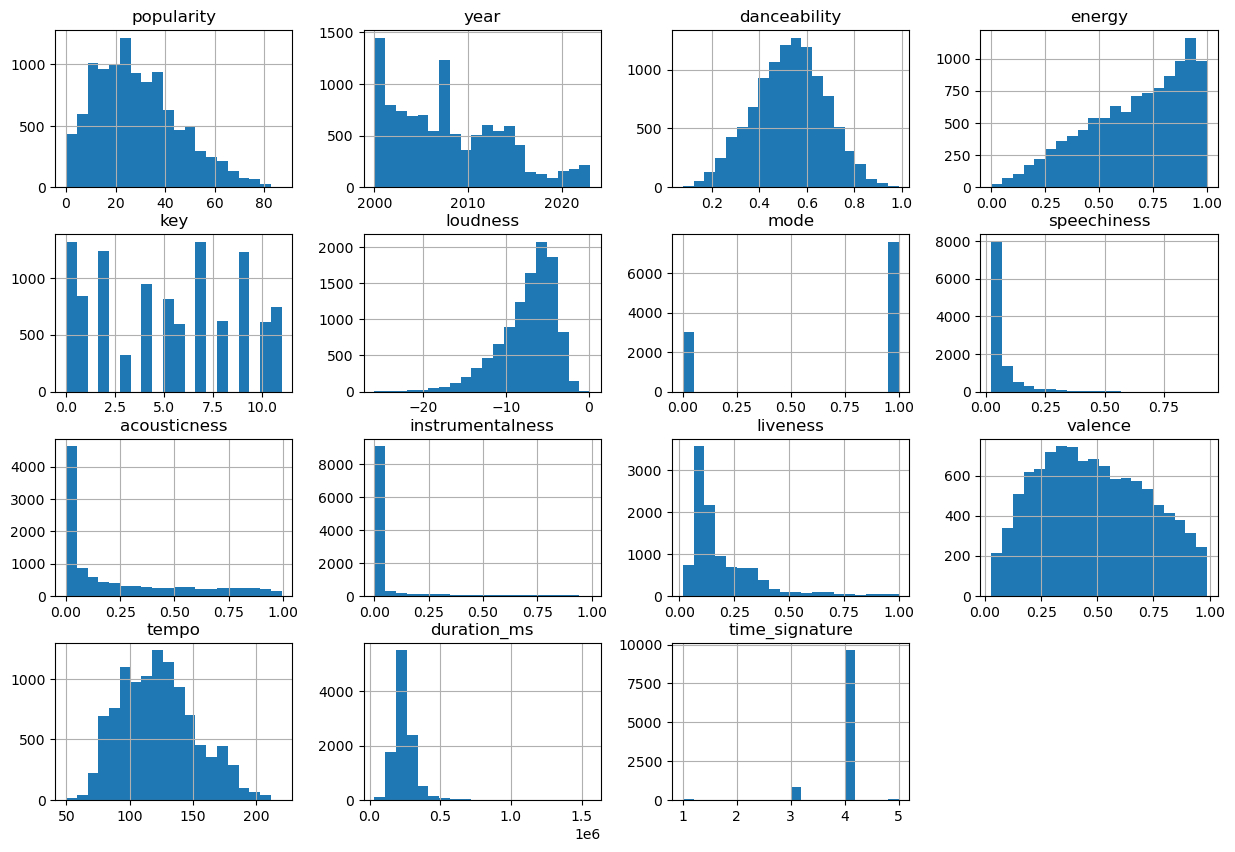

In [56]:
final_df.hist(bins=20, figsize=(15, 10))
plt.show()

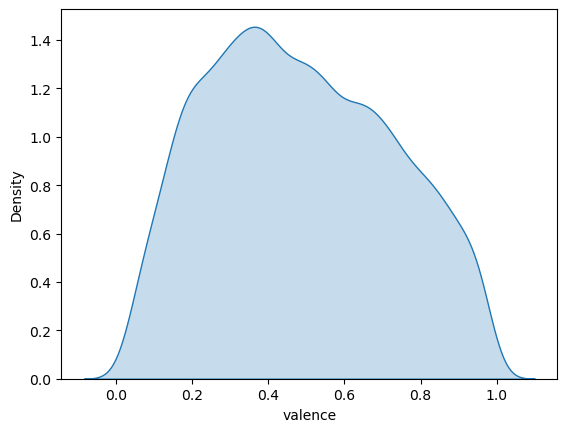

In [57]:
sns.kdeplot(final_df['valence'], fill=True)
plt.show()

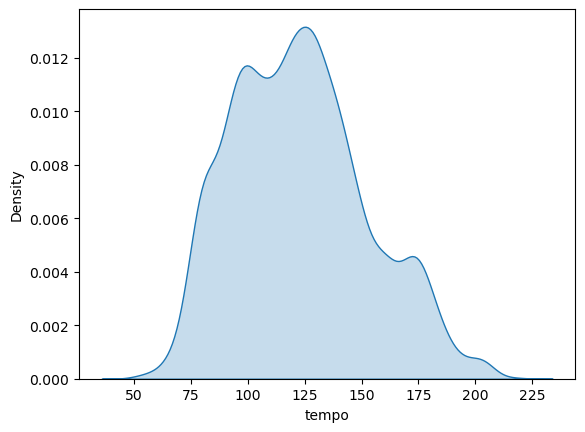

In [58]:
sns.kdeplot(final_df['tempo'], fill=True)
plt.show()

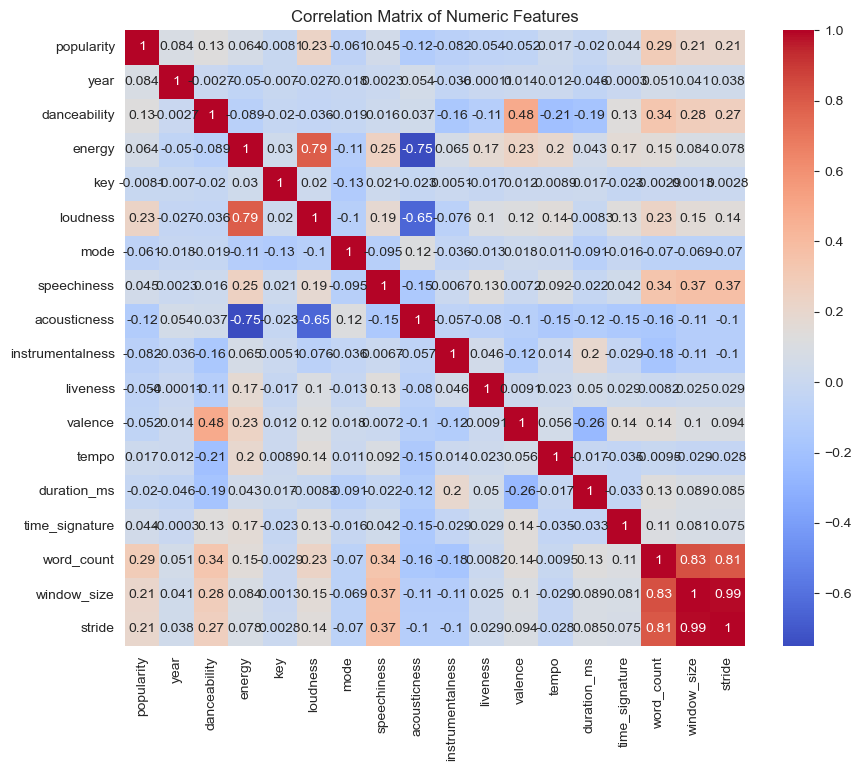

In [26]:
# Select only numeric columns
numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix using only numeric columns
corr_matrix = final_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

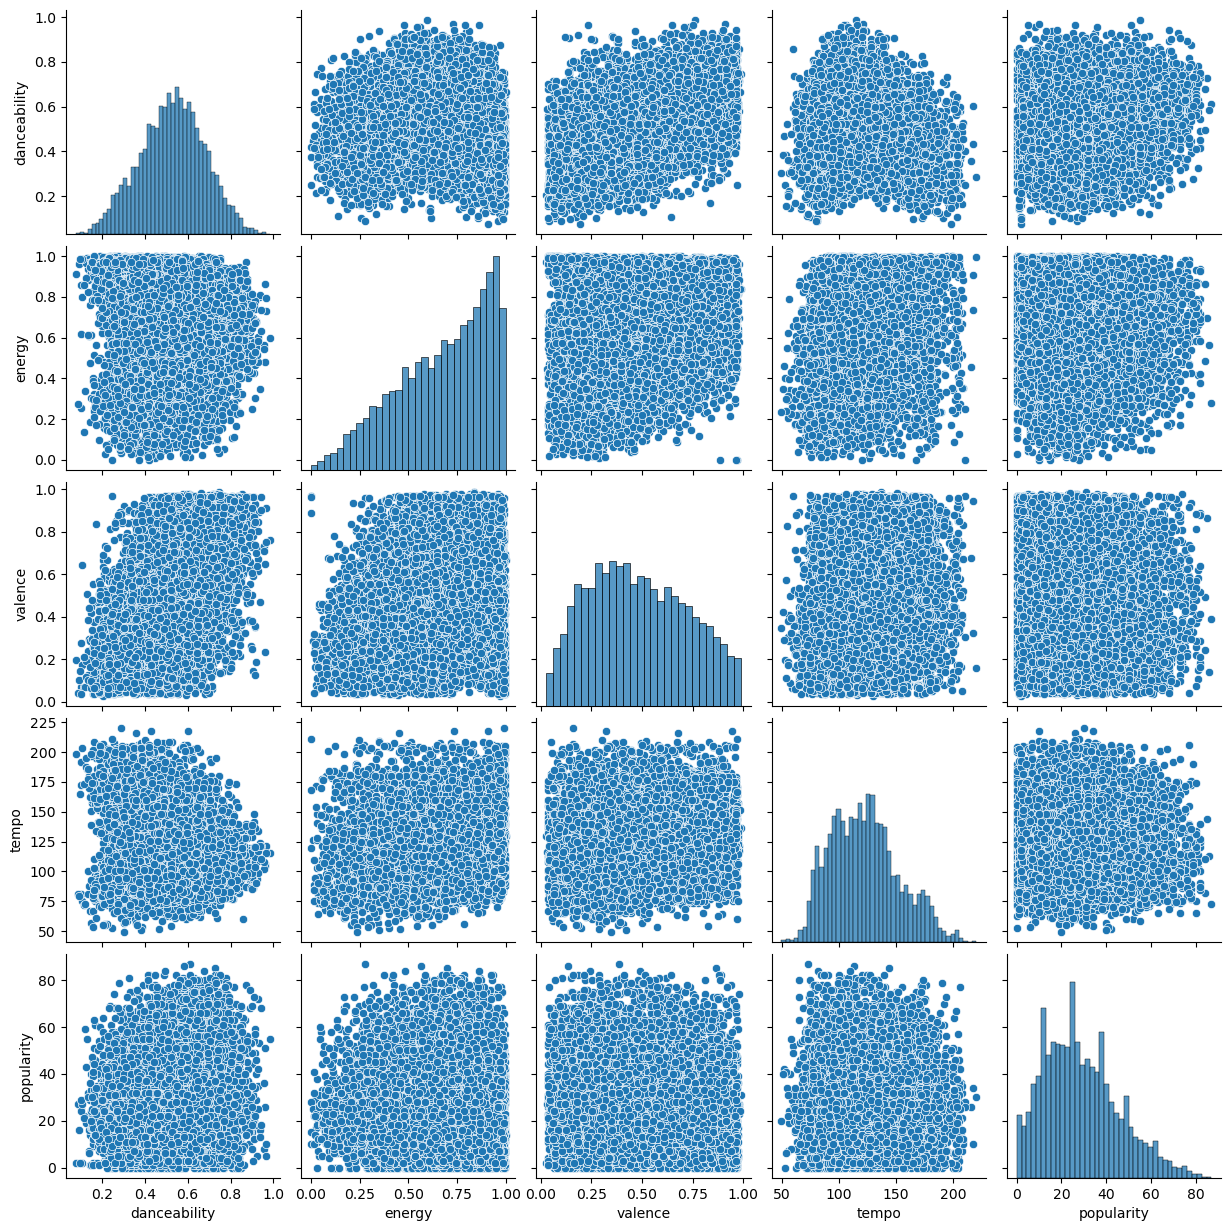

In [60]:
sns.pairplot(final_df[['danceability', 'energy', 'valence', 'tempo', 'popularity']])
plt.show()

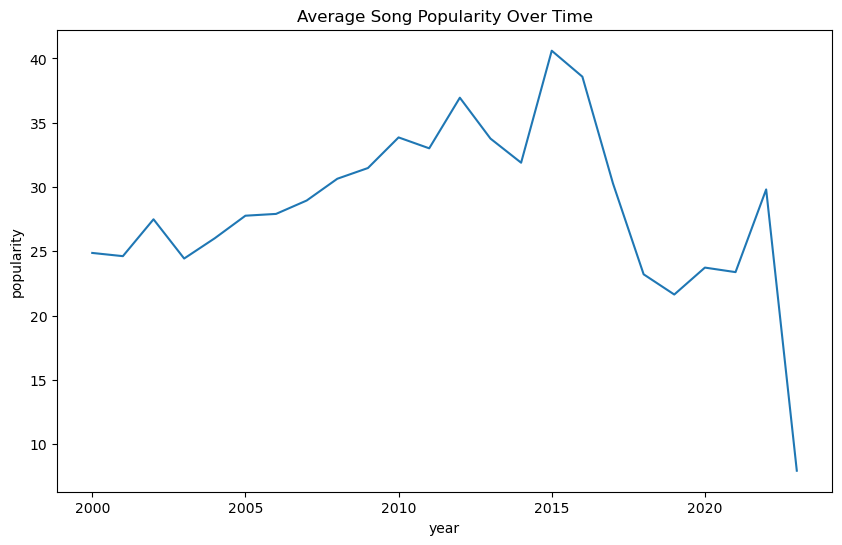

In [61]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='year', y='popularity', errorbar=None)
plt.title('Average Song Popularity Over Time')
plt.show()

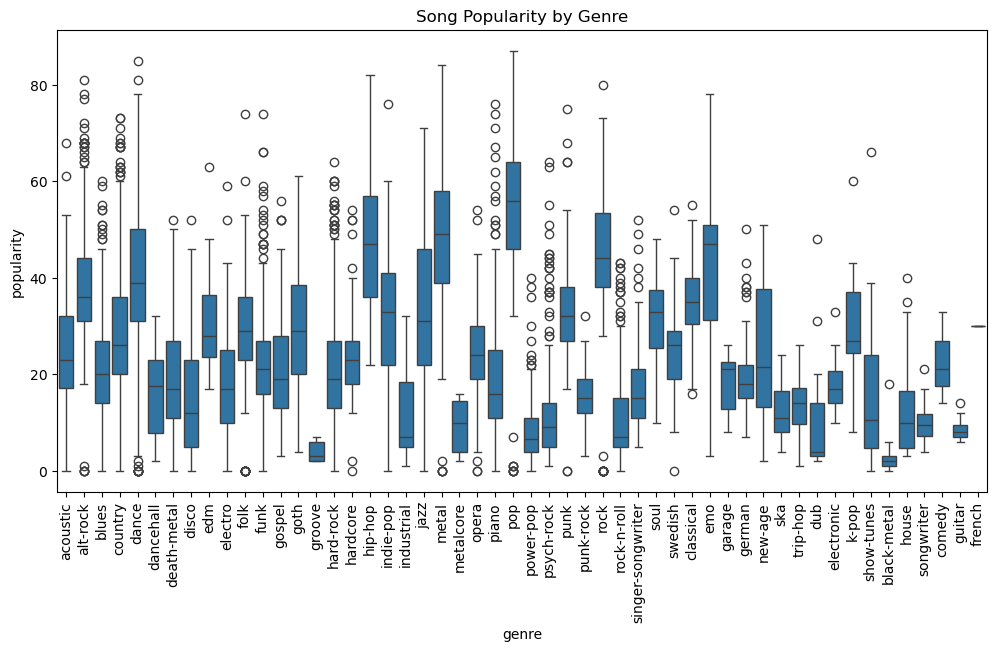

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='genre', y='popularity')
plt.xticks(rotation=90)
plt.title('Song Popularity by Genre')
plt.show()

In [27]:
final_df

artist_clean                            song_clean  \
0         jason mraz                       i won't give up   
1         jason mraz                      93 million miles   
8         jason mraz                  living in the moment   
13        jason mraz                      the woman i love   
21        jason mraz                     winter wonderland   
...              ...                                   ...   
1147305    jim croce                              recently   
1147349    jim croce                      salon and saloon   
1150035      roxette                  church of your heart   
1150045      roxette  she's got nothing on (but the radio)   
1150105      roxette            no one makes it on her own   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      lyrics_clean  \
0                                                                                                                                                                                                                               when i look into your eyes it's like watching the night sky or a beautiful sunrise there's so much they hold and just like them old stars i see that you've come so far to be right where you are how old is your soul? i won't give up on us, even if the skies get rough i'm giving you all my love, i'm still looking up and when you're needing your space, to do some navigating i'll be here patiently waiting, to see what you find 'cause even the stars they burn some even fall to the earth we've got a lot to learn god knows we're worth it no, i won't give up i don't wanna be someone who walks away so easily i'm here to stay and make the difference that i can make our differences they do a lot to teach us how to use the tools and gifts we got yeah, we got a lot at stake and in the end, you're still my friend at least we did intend for us to work we didn't break, we didn't burn we had to learn how to bend without the world caving in i had to learn what i've got, and what i'm not and who i am i won't give up on us, even if the skies get rough i'm giving you all my love i'm still looking up, still looking up. i won't give up on us (no i'm not giving up) god knows i'm tough enough (i am tough, i am loved) we've got a lot to learn (we're alive, we are loved) god knows we're worth it (and we're worth it) i won't give up on us, even if the skies get rough i'm giving you all my love, i'm still l

In [24]:
# Now, I'm considering making the sentiment vector to help perform EDA...
# To begin, I want to find out how to split the songs up into chunks to capture sentiment over the lyrics
# -> I am considering a sliding window type technique which contains overlap between sentiment chunks, to 
#    better capture the change from bit to bit

# calculate word count for each song
# assuming 'lyrics_clean' is the column containing the cleaned lyrics
final_df['word_count'] = final_df['lyrics_clean'].apply(lambda x: len(str(x).split()))

# calculate descriptive statistics for song lengths (word count)
mean_word_count = final_df['word_count'].mean()
median_word_count = final_df['word_count'].median()
min_word_count = final_df['word_count'].min()
max_word_count = final_df['word_count'].max()

# display statistics
print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"Minimum word count: {min_word_count}")
print(f"Maximum word count: {max_word_count}")

Mean word count: 238.8519392280834
Median word count: 215.0
Minimum word count: 57
Maximum word count: 805


/var/folders/56/ntwrbpx9491dpp44ysgs9q380000gn/T/ipykernel_555/4105543619.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['word_count'] = final_df['lyrics_clean'].apply(lambda x: len(str(x).split()))


count    10597.000000
mean       238.851939
std        114.267034
min         57.000000
25%        158.000000
50%        215.000000
75%        291.000000
max        805.000000
Name: word_count, dtype: float64


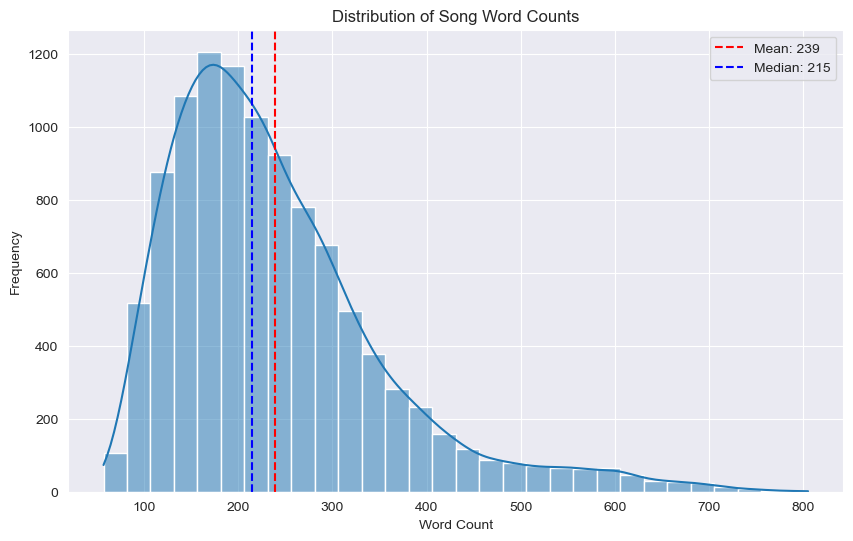

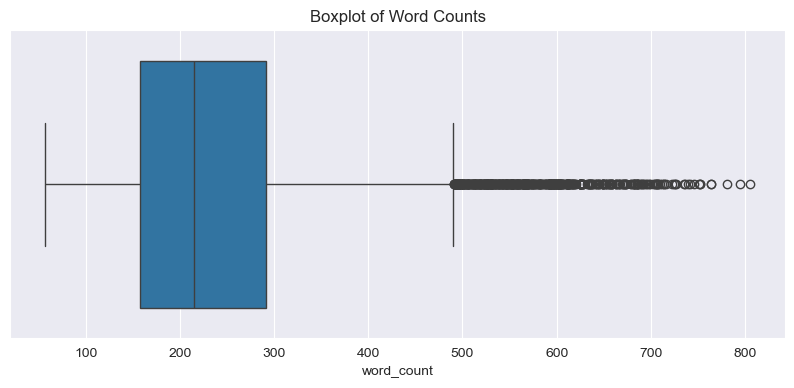

In [28]:
# descriptive statistics summary
desc_stats = final_df['word_count'].describe()
print(desc_stats)

# plot histogram for word counts
plt.figure(figsize=(10, 6))
sns.histplot(final_df['word_count'], bins=30, kde=True)
plt.axvline(final_df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {final_df["word_count"].mean():.0f}')
plt.axvline(final_df['word_count'].median(), color='blue', linestyle='--', label=f'Median: {final_df["word_count"].median():.0f}')
plt.title('Distribution of Song Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# plot boxplot to identify range and outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=final_df['word_count'])
plt.title('Boxplot of Word Counts')
plt.show()

In [4]:
# calculate window and stride sizes based on word count to track changing sentiment over song
median_word_count = final_df['word_count'].median()
mean_word_count = final_df['word_count'].mean()
def calculate_window_and_stride(word_count, num_windows=20):
    window_size = word_count // num_windows  
    stride = window_size  
    return window_size, stride

# apply the function to the dataframe
final_df['window_size'], final_df['stride'] = zip(*final_df['word_count'].apply(lambda x: calculate_window_and_stride(x)))

In [5]:
# save
final_df.to_csv('wordcount_dataset.csv', index=False)

In [6]:
final_df = pd.read_csv('wordcount_dataset.csv')

In [7]:
final_df.head()

artist_clean            song_clean  \
0   jason mraz       i won't give up   
1   jason mraz      93 million miles   
2   jason mraz  living in the moment   
3   jason mraz      the woman i love   
4   jason mraz     winter wonderland   

                                        lyrics_clean  popularity  year  \
0  when i look into your eyes it's like watching ...          68  2012   
1  93 million miles from the sun people get ready...          50  2012   
2  if this life is one act why do we lay all thes...          44  2012   
3  maybe i annoy you with my choices well, you an...          40  2012   
4  sleigh bells ring, are you listening, in the l...          36  2012   

      genre  danceability  energy  key  loudness  ...  acousticness  \
0  acoustic         0.483   0.303    4   -10.058  ...        0.6940   
1  acoustic         0.572   0.454    3   -10.286  ...        0.4770   
2  acoustic         0.650   0.628    7    -7.160  ...        0.0483   
3  acoustic         0.591   0.647    4    -8.340  ...        0.0670   
4  acoustic         0.609   0.359    5    -6.715  ...        0.7770   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000000    0.1150    0.139  133.406       240166               3   
1          0.000014    0.0974    0.515  140.182       216387               4   
2          0.000000    0.1190    0.700   84.141       235080               4   
3          0.000066    0.2310    0.678   79.680       190752               4   
4          0.000000    0.2210    0.645  145.178       127080               4   

   word_count  window_size  stride  
0         301           15      15  
1         223           11      11  
2         348           17      17  
3         186            9       9  
4         171            8       8  

[5 rows x 22 columns]

In [46]:
# print the entire value in lyrics_clean for the first 5 rows
print(final_df['lyrics_clean'].iloc[:5])
pd.set_option('display.max_colwidth', None)

0                                                                                                                                                                                                                            when i look into your eyes it's like watching the night sky or a beautiful sunrise there's so much they hold and just like them old stars i see that you've come so far to be right where you are how old is your soul? i won't give up on us, even if the skies get rough i'm giving you all my love, i'm still looking up and when you're needing your space, to do some navigating i'll be here patiently waiting, to see what you find 'cause even the stars they burn some even fall to the earth we've got a lot to learn god knows we're worth it no, i won't give up i don't wanna be someone who walks away so easily i'm here to stay and make the difference that i can make our differences they do a lot to teach us how to use the tools and gifts we got yeah, we got a lot at stake and in 

In [8]:
# load the emotion classification model using the pipeline
classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    top_k=None,  
    device=0
)

/Users/rutvashah/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
# function to create sliding windows for lyrics
def create_sliding_windows(song_lyrics, num_windows=20):
    # tokenize the lyrics 
    tokens = song_lyrics.split()

    # calculate exact window size
    total_tokens = len(tokens)
    window_size = total_tokens / num_windows  

    windows = []
    start_idx = 0

    # distribute tokens evenly across 20 windows
    for i in range(num_windows):
        end_idx = round((i + 1) * window_size)
        window = tokens[start_idx:end_idx]
        windows.append(' '.join(window))  # Join tokens back into a string
        start_idx = end_idx

    return windows

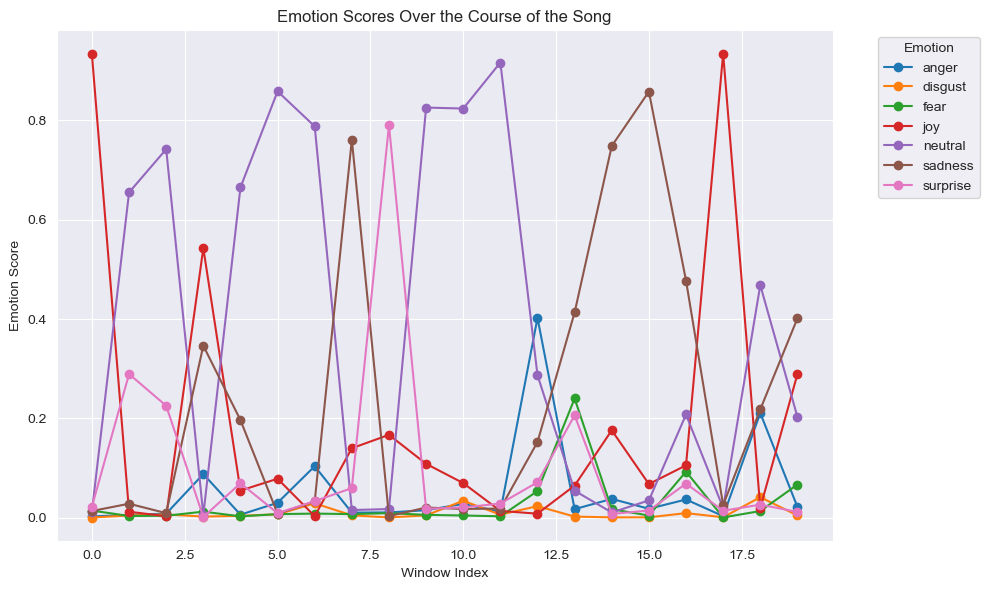

In [34]:
# test on the first song dynamically from the df
first_song = final_df.iloc[0]  # get the first row/song

# extract lyrics, window size, and stride
lyrics = first_song['lyrics_clean']
window_size = first_song['window_size']
stride = first_song['stride']

# create sliding windows
windows = create_sliding_windows(lyrics, 20)

# run sentiment analysis on each window
results = classifier(windows)

# create a df to store emotion data for each window
emotion_data = []

# collect emotion scores for each window
for i, window in enumerate(windows):
    for emotion in results[i]:
        emotion_data.append({
            "window_index": i,
            "window_text": window,
            "emotion": emotion['label'],
            "score": emotion['score']
        })

# convert to a df for easy plotting
emotion_df = pd.DataFrame(emotion_data)
emotion_pivot = emotion_df.pivot(index='window_index', columns='emotion', values='score').reset_index()

# plot emotion scores over the course of the song
emotion_pivot.plot(x='window_index', figsize=(10, 6), marker='o')

plt.title("Emotion Scores Over the Course of the Song")
plt.xlabel("Window Index")
plt.ylabel("Emotion Score")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# function to run sentiment analysis on a song's lyrics with dynamic windows
def analyze_song_emotions(song_row):
    lyrics = song_row['lyrics_clean']
    windows = create_sliding_windows(lyrics, 20)
    results = classifier(windows)
    emotion_data = []
    
    # collect emotion scores for each window
    for i, window in enumerate(windows):
        for emotion in results[i]:
            emotion_data.append({
                "song": song_row['song_clean'],
                "artist": song_row['artist_clean'],
                "window_index": i,
                "window_text": window,
                "emotion": emotion['label'],
                "score": emotion['score']
            })
    return pd.DataFrame(emotion_data)

# apply the emotion analysis to each song in the df
emotion_results = pd.concat([analyze_song_emotions(row) for _, row in final_df.iterrows()], ignore_index=True)
emotion_results.to_csv('emotion_results.csv', index=False)

In [36]:
# pivot df to create a column for each emotion
emotion_pivot = emotion_results.pivot_table(
    index=['song', 'artist', 'window_index', 'window_text'],  # Keep these as index
    columns='emotion',  
    values='score',  
    fill_value=0
)

emotion_pivot.reset_index(inplace=True)

In [37]:
emotion_pivot.head(10)

emotion         song      artist  window_index  \
0        'cello song  nick drake             0   
1        'cello song  nick drake             1   
2        'cello song  nick drake             2   
3        'cello song  nick drake             3   
4        'cello song  nick drake             4   
5        'cello song  nick drake             5   
6        'cello song  nick drake             6   
7        'cello song  nick drake             7   
8        'cello song  nick drake             8   
9        'cello song  nick drake             9   

emotion                            window_text     anger   disgust      fear  \
0              strange face, with your eyes so  0.065967  0.106821  0.058204   
1        pale and sincere. underneath you know  0.016460  0.019454  0.001729   
2                     well you have nothing to  0.040916  0.043261  0.006458   
3               fear. for the dreams that came  0.001655  0.000556  0.987908   
4                    to you when so young told  0.021743  0.511265  0.145783   
5                       of a life where spring  0.019968  0.001861  0.014396   
6                 is sprung. you would seem so  0.004986  0.000990  0.001429   
7                     frail in the cold of the  0.624979  0.039131  0.209112   
8             night when the armies of emotion  0.033617  0.032122  0.059506   
9                   go out to fight. but while  0.006224  0.001292  0.001866   

emotion       joy   neutral   sadness  surprise  
0        0.008699  0.388427  0.081881  0.290001  
1        0.433025  0.465987  0.047542  0.015804  
2        0.005419  0.875789  0.011260  0.016896  
3        0.001264  0.002589  0.004897  0.001132  
4        0.169797  0.094333  0.037032  0.020048  
5        0.650845  0.123972  0.127303  0.061655  
6        0.003677  0.084282  0.004484  0.900153  
7        0.006938  0.042286  0.073819  0.003735  
8        0.007183  0.211999  0.156047  0.499527  
9        0.032443  0.161077  0.625318  0.171779

In [38]:
# rename columns in the emotion DataFrame to match the final_df
emotion_pivot.rename(columns={'song': 'song_clean', 'artist': 'artist_clean'}, inplace=True)
# merge using the corrected column names
final_df_with_emotions = pd.merge(final_df, emotion_pivot, on=['song_clean', 'artist_clean'], how='left')

final_df_with_emotions.head()

artist_clean       song_clean  \
0   jason mraz  i won't give up   
1   jason mraz  i won't give up   
2   jason mraz  i won't give up   
3   jason mraz  i won't give up   
4   jason mraz  i won't give up   

                                        lyrics_clean  popularity  year  \
0  when i look into your eyes it's like watching ...          68  2012   
1  when i look into your eyes it's like watching ...          68  2012   
2  when i look into your eyes it's like watching ...          68  2012   
3  when i look into your eyes it's like watching ...          68  2012   
4  when i look into your eyes it's like watching ...          68  2012   

      genre  danceability  energy  key  loudness  ...  stride  window_index  \
0  acoustic         0.483   0.303    4   -10.058  ...      15             0   
1  acoustic         0.483   0.303    4   -10.058  ...      15             1   
2  acoustic         0.483   0.303    4   -10.058  ...      15             2   
3  acoustic         0.483   0.303    4   -10.058  ...      15             3   
4  acoustic         0.483   0.303    4   -10.058  ...      15             4   

                                         window_text     anger   disgust  \
0  when i look into your eyes it's like watching ...  0.002872  0.000694   
1  sunrise there's so much they hold and just lik...  0.005971  0.004903   
2  you've come so far to be right where you are h...  0.008515  0.006889   
3  i won't give up on us, even if the skies get r...  0.088137  0.002622   
4  all my love, i'm still looking up and when you...  0.006475  0.004126   

       fear       joy   neutral   sadness  surprise  
0  0.014730  0.932730  0.012456  0.013844  0.022674  
1  0.003788  0.012387  0.654966  0.028482  0.289503  
2  0.004271  0.003231  0.741992  0.009496  0.225607  
3  0.012525  0.542928  0.005592  0.346509  0.001687  
4  0.003085  0.054925  0.664923  0.196760  0.069705  

[5 rows x 31 columns]

In [39]:
final_df_with_emotions.to_csv('final_df_with_emotions.csv', index=False)


anger        disgust           fear            joy  \
count  242435.000000  242435.000000  242435.000000  242435.000000   
mean        0.122456       0.033591       0.081266       0.144172   
std         0.223225       0.090352       0.192725       0.261971   
min         0.000375       0.000093       0.000143       0.000260   
25%         0.008421       0.002717       0.004153       0.005970   
50%         0.023660       0.007549       0.012130       0.018943   
75%         0.098778       0.023542       0.044819       0.114141   
max         0.995440       0.988357       0.996107       0.995186   

             neutral        sadness       surprise  
count  242435.000000  242435.000000  242435.000000  
mean        0.272127       0.206819       0.139569  
std         0.284000       0.292093       0.215035  
min         0.000176       0.000547       0.000226  
25%         0.030247       0.018335       0.011459  
50%         0.151438       0.056898       0.042377  
75%         0.473743       0.259348       0.158434  
max         0.975431       0.994386       0.986962

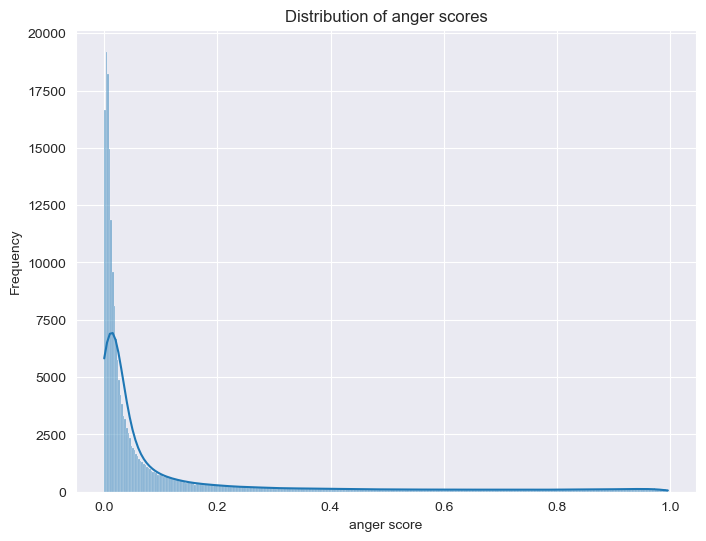

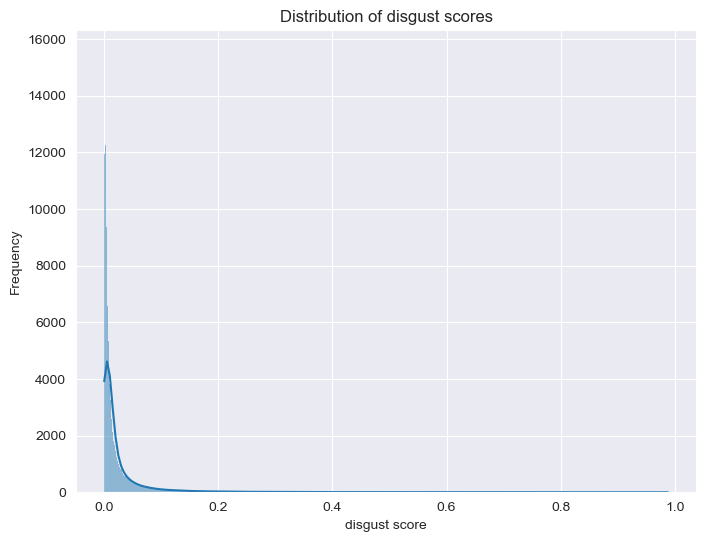

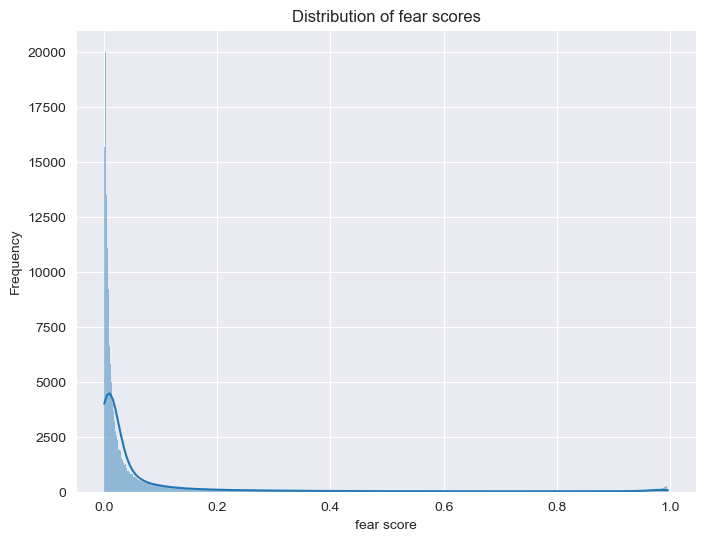

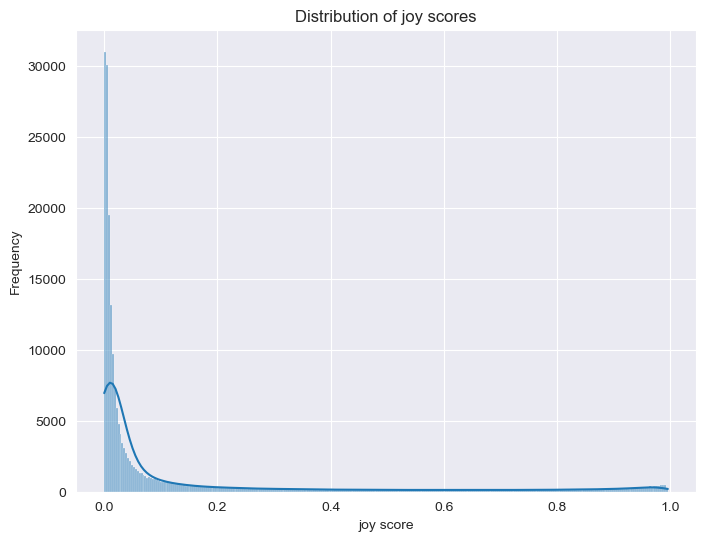

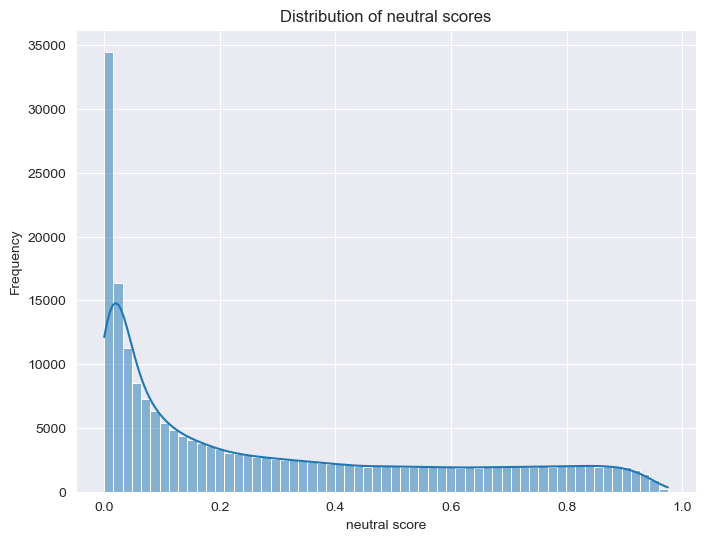

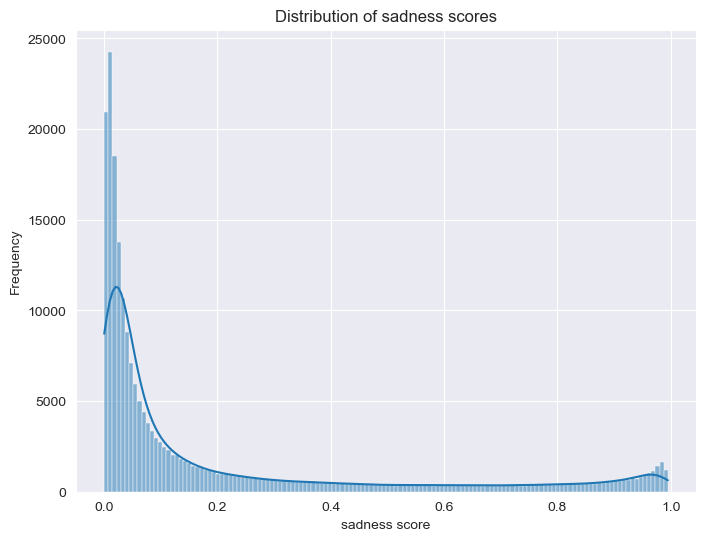

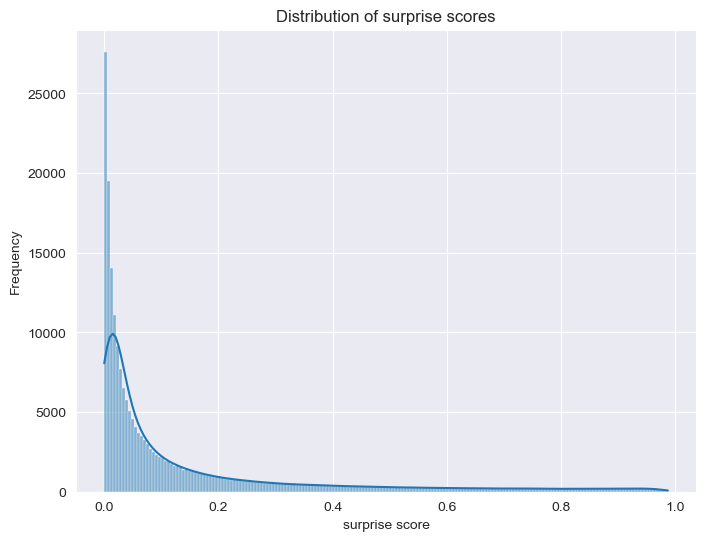

In [40]:
# plot the distribution of each emotion
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']  # Example emotion columns

for emotion in emotion_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(final_df_with_emotions[emotion], kde=True)
    plt.title(f"Distribution of {emotion} scores")
    plt.xlabel(f"{emotion} score")
    plt.ylabel("Frequency")
    plt.show()

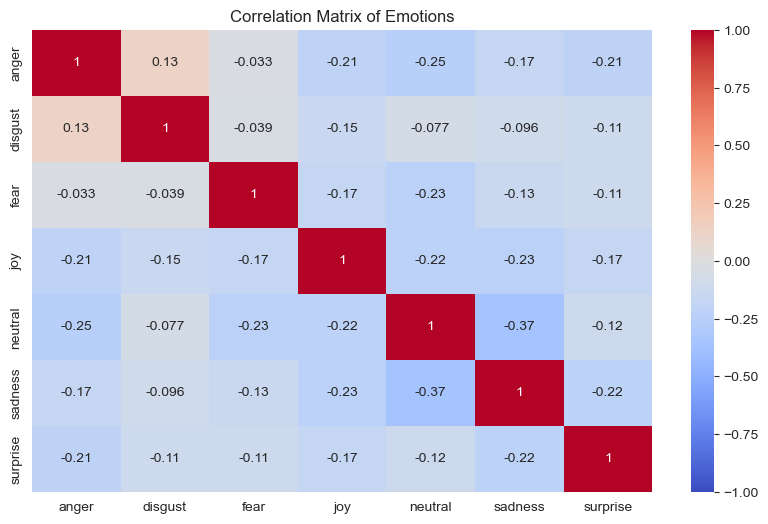

In [42]:
# Correlation matrix
correlation_matrix = final_df_with_emotions[emotion_columns].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Emotions')
plt.show()

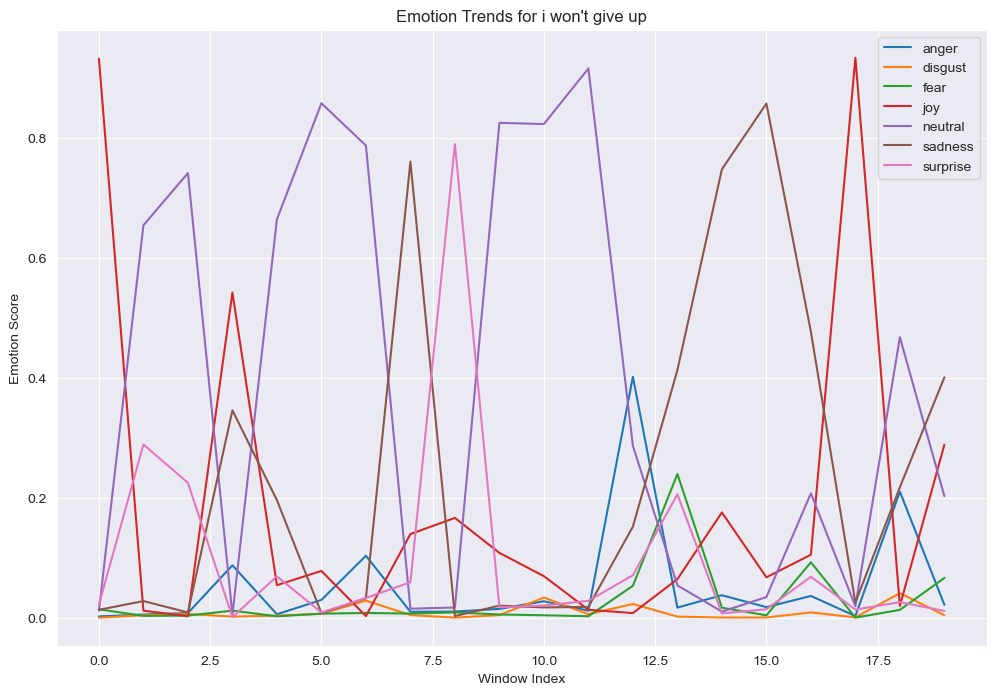

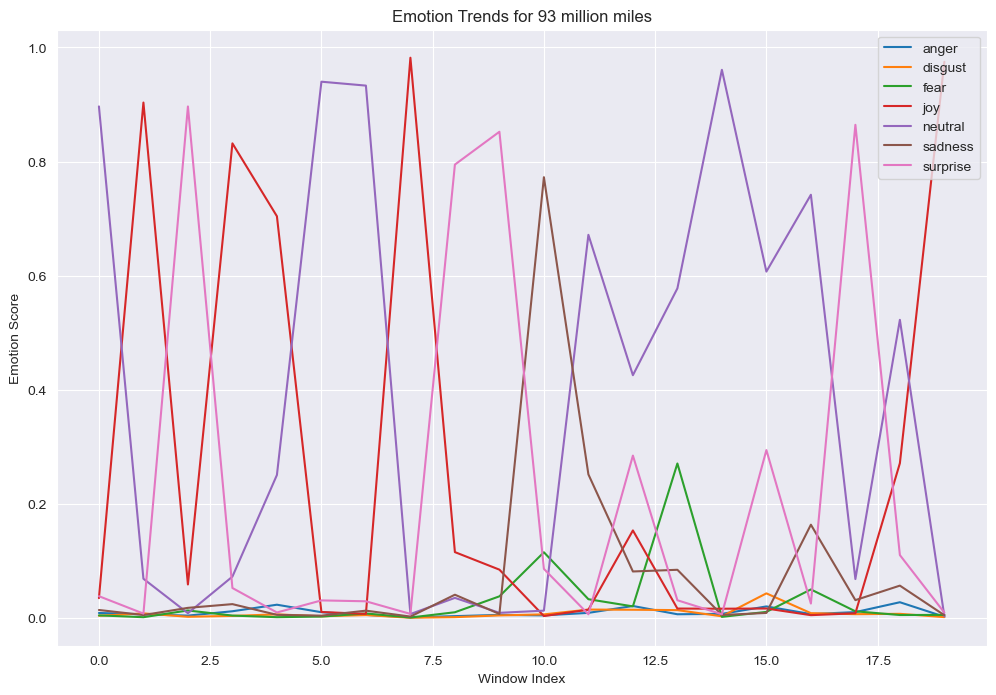

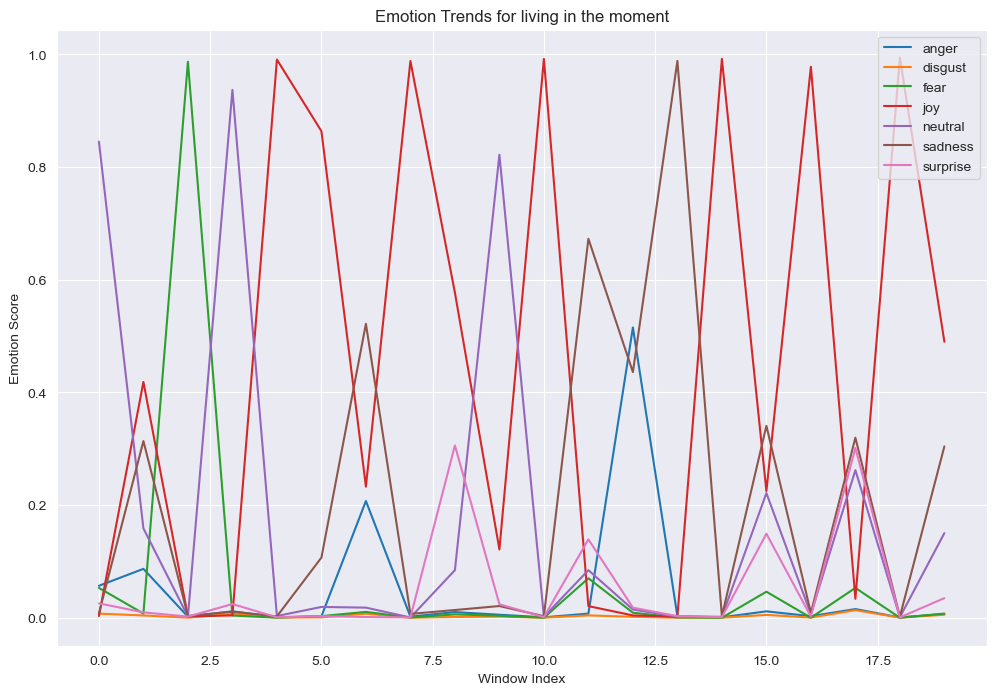

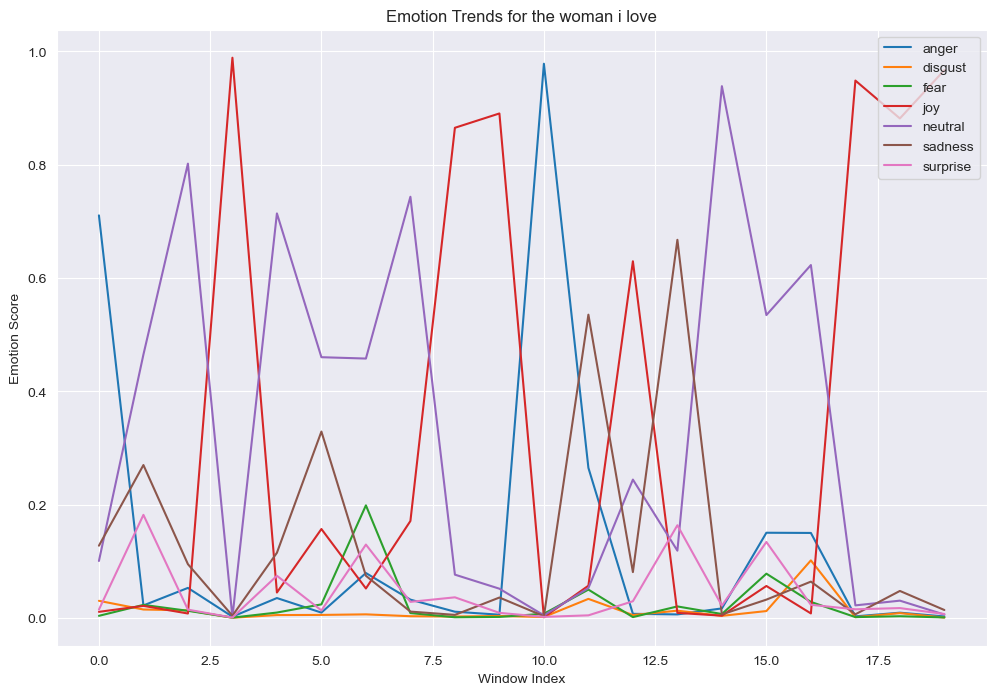

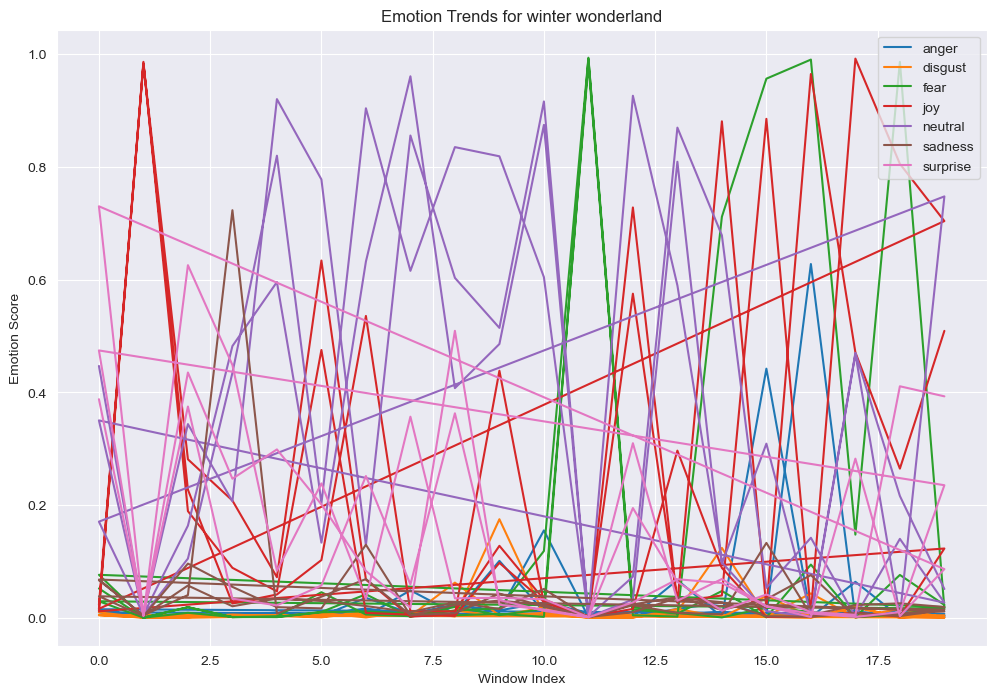

In [43]:
# first 5 unique songs from the df
first_five_songs = final_df_with_emotions['song_clean'].unique()[:5]

# plot emotion trends for each of the first 5 songs
for song_name in first_five_songs:
    song_data = final_df_with_emotions[final_df_with_emotions['song_clean'] == song_name]
    
    plt.figure(figsize=(12, 8))
    for emotion in emotion_columns:  # Assuming emotion_columns has the 7 emotions
        plt.plot(song_data['window_index'], song_data[emotion], label=emotion)

    plt.title(f"Emotion Trends for {song_name}")
    plt.xlabel("Window Index")
    plt.ylabel("Emotion Score")
    plt.legend(loc='upper right')
    plt.show()

In [45]:
# CLEARLY THERE IS A PROBLEM WITH DUPLICATE SONGS...
# group by 'song_clean' and count the number of occurrences for each song
song_counts = final_df_with_emotions.groupby('song_clean').size()

# filter for songs that appear more than 20 times (which would indicate duplicates)
duplicate_songs = song_counts[song_counts > 20].reset_index()
duplicate_songs = duplicate_songs.merge(final_df[['artist_clean', 'song_clean']], on='song_clean', how='left')

# display the songs with more than 20 occurrences
print(duplicate_songs)

               song_clean   0     artist_clean
0                      27  40        passenger
1                      27  40     fall out boy
2         a long time ago  40  waylon jennings
3         a long time ago  40        jim croce
4        a matter of time  40      the killers
...                   ...  ..              ...
1656         you found me  40  israel houghton
1657       you're the one  40       paul simon
1658       you're the one  40    tracy chapman
1659  your cheatin' heart  40    frankie laine
1660  your cheatin' heart  40    hank williams

[1661 rows x 3 columns]


In [46]:
# create a new column 'song_artist' that combines 'song_clean' and 'artist_clean'
final_df_with_emotions['song_artist'] = final_df_with_emotions['song_clean'] + ' - ' + final_df_with_emotions['artist_clean']

# drop the original columns
final_df_with_emotions = final_df_with_emotions.drop(columns=['song_clean', 'artist_clean'])

final_df_with_emotions.head()

lyrics_clean  popularity  year  \
0  when i look into your eyes it's like watching ...          68  2012   
1  when i look into your eyes it's like watching ...          68  2012   
2  when i look into your eyes it's like watching ...          68  2012   
3  when i look into your eyes it's like watching ...          68  2012   
4  when i look into your eyes it's like watching ...          68  2012   

      genre  danceability  energy  key  loudness  mode  speechiness  ...  \
0  acoustic         0.483   0.303    4   -10.058     1       0.0429  ...   
1  acoustic         0.483   0.303    4   -10.058     1       0.0429  ...   
2  acoustic         0.483   0.303    4   -10.058     1       0.0429  ...   
3  acoustic         0.483   0.303    4   -10.058     1       0.0429  ...   
4  acoustic         0.483   0.303    4   -10.058     1       0.0429  ...   

   window_index                                        window_text     anger  \
0             0  when i look into your eyes it's like watching ...  0.002872   
1             1  sunrise there's so much they hold and just lik...  0.005971   
2             2  you've come so far to be right where you are h...  0.008515   
3             3  i won't give up on us, even if the skies get r...  0.088137   
4             4  all my love, i'm still looking up and when you...  0.006475   

    disgust      fear       joy   neutral   sadness  surprise  \
0  0.000694  0.014730  0.932730  0.012456  0.013844  0.022674   
1  0.004903  0.003788  0.012387  0.654966  0.028482  0.289503   
2  0.006889  0.004271  0.003231  0.741992  0.009496  0.225607   
3  0.002622  0.012525  0.542928  0.005592  0.346509  0.001687   
4  0.004126  0.003085  0.054925  0.664923  0.196760  0.069705   

                    song_artist  
0  i won't give up - jason mraz  
1  i won't give up - jason mraz  
2  i won't give up - jason mraz  
3  i won't give up - jason mraz  
4  i won't give up - jason mraz  

[5 rows x 30 columns]

In [49]:
# split the 'song_artist' column to get the song and artist separately
final_df_with_emotions[['song_clean', 'artist_clean']] = final_df_with_emotions['song_artist'].str.split(' - ', expand=True)

# check if the columns were restored correctly
final_df_with_emotions.head()

ValueError: Columns must be same length as key

In [48]:
# move 'song_artist' to be key
columns = ['song_artist'] + [col for col in final_df_with_emotions.columns if col != 'song_artist']
final_df_with_emotions = final_df_with_emotions[columns]

final_df_with_emotions.head()


song_artist  \
0  i won't give up - jason mraz   
1  i won't give up - jason mraz   
2  i won't give up - jason mraz   
3  i won't give up - jason mraz   
4  i won't give up - jason mraz   

                                        lyrics_clean  popularity  year  \
0  when i look into your eyes it's like watching ...          68  2012   
1  when i look into your eyes it's like watching ...          68  2012   
2  when i look into your eyes it's like watching ...          68  2012   
3  when i look into your eyes it's like watching ...          68  2012   
4  when i look into your eyes it's like watching ...          68  2012   

      genre  danceability  energy  key  loudness  mode  ...  stride  \
0  acoustic         0.483   0.303    4   -10.058     1  ...      15   
1  acoustic         0.483   0.303    4   -10.058     1  ...      15   
2  acoustic         0.483   0.303    4   -10.058     1  ...      15   
3  acoustic         0.483   0.303    4   -10.058     1  ...      15   
4  acoustic         0.483   0.303    4   -10.058     1  ...      15   

   window_index                                        window_text     anger  \
0             0  when i look into your eyes it's like watching ...  0.002872   
1             1  sunrise there's so much they hold and just lik...  0.005971   
2             2  you've come so far to be right where you are h...  0.008515   
3             3  i won't give up on us, even if the skies get r...  0.088137   
4             4  all my love, i'm still looking up and when you...  0.006475   

    disgust      fear       joy   neutral   sadness  surprise  
0  0.000694  0.014730  0.932730  0.012456  0.013844  0.022674  
1  0.004903  0.003788  0.012387  0.654966  0.028482  0.289503  
2  0.006889  0.004271  0.003231  0.741992  0.009496  0.225607  
3  0.002622  0.012525  0.542928  0.005592  0.346509  0.001687  
4  0.004126  0.003085  0.054925  0.664923  0.196760  0.069705  

[5 rows x 30 columns]

In [50]:
final_df_with_emotions.to_csv('final_df_with_emotions.csv', index=False)


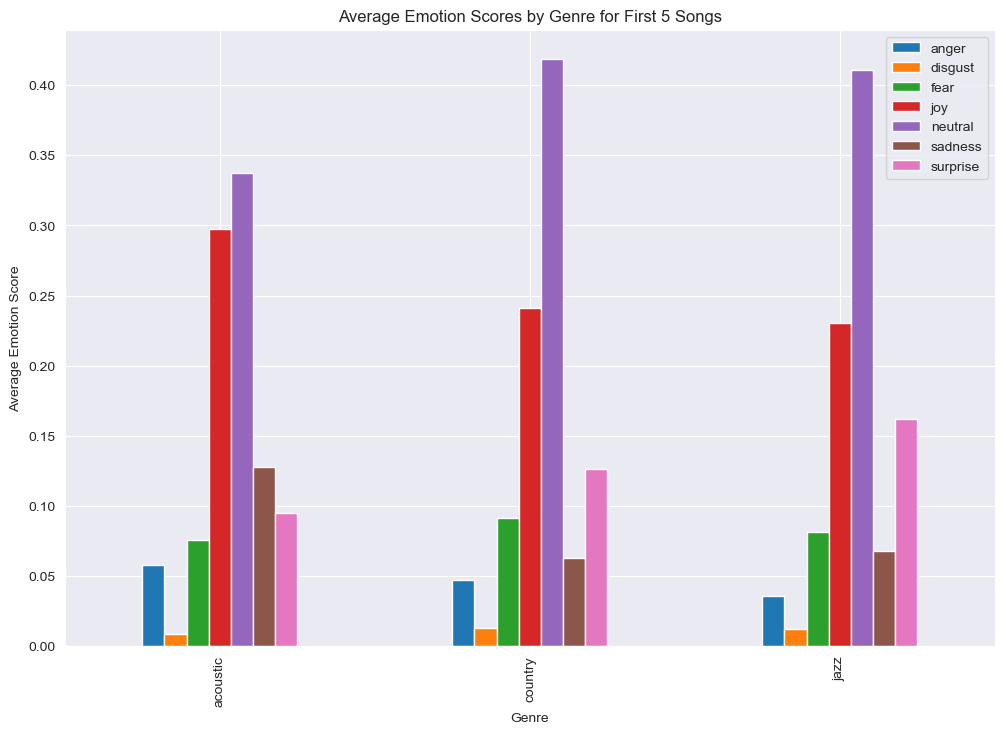

In [29]:
# filter the data to only include the first 5 songs
first_five_songs_df = final_df_with_emotions[final_df_with_emotions['song_clean'].isin(first_five_songs)]

# aggregate the mean emotion scores by genre
genre_emotions = first_five_songs_df.groupby('genre')[emotion_columns].mean()

# plot the emotion profiles for each genre in the first 5 songs
genre_emotions.plot(kind='bar', figsize=(12, 8))
plt.title('Average Emotion Scores by Genre for First 5 Songs')
plt.ylabel('Average Emotion Score')
plt.xlabel('Genre')
plt.legend(loc='upper right')
plt.show()

In [30]:
eda_df = final_df_with_emotions
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
eda_df[emotion_columns].describe()

anger        disgust           fear            joy  \
count  218849.000000  218849.000000  218849.000000  218849.000000   
mean        0.114767       0.033668       0.075215       0.137407   
std         0.215170       0.090167       0.181385       0.255396   
min         0.000392       0.000093       0.000146       0.000299   
25%         0.008479       0.002887       0.004123       0.005935   
50%         0.022382       0.007779       0.011683       0.017803   
75%         0.087443       0.023592       0.042332       0.102777   
max         0.995735       0.988669       0.996228       0.995110   

             neutral        sadness       surprise  
count  218849.000000  218849.000000  218849.000000  
mean        0.296299       0.196124       0.146521  
std         0.293411       0.283497       0.217211  
min         0.000165       0.000595       0.000234  
25%         0.036462       0.018045       0.013063  
50%         0.181761       0.053741       0.048094  
75%         0.526381       0.232326       0.173419  
max         0.975177       0.994542       0.986703

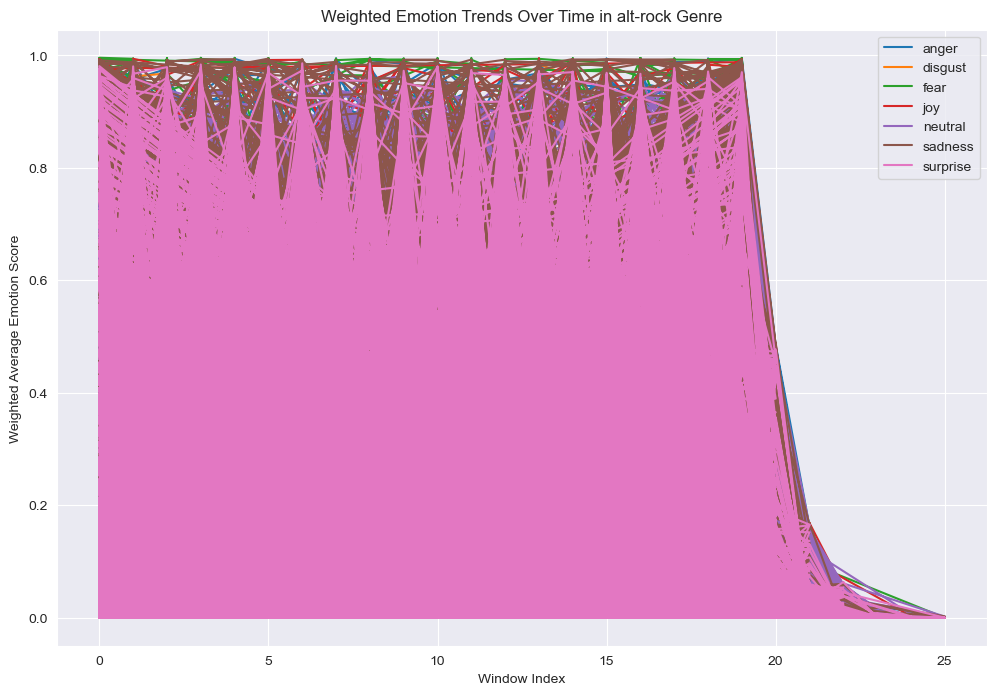

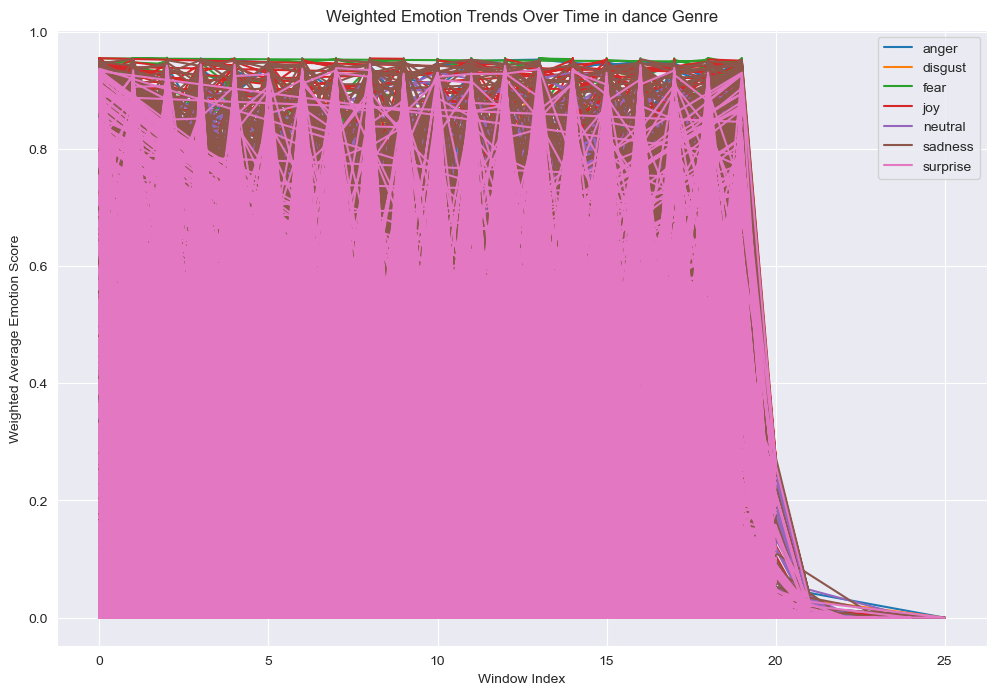

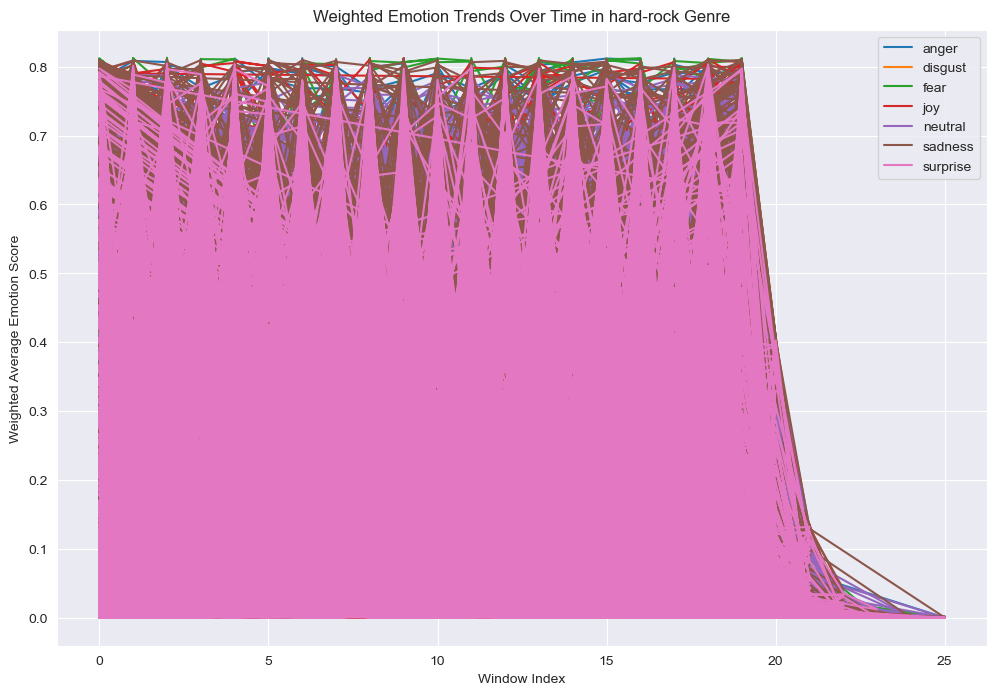

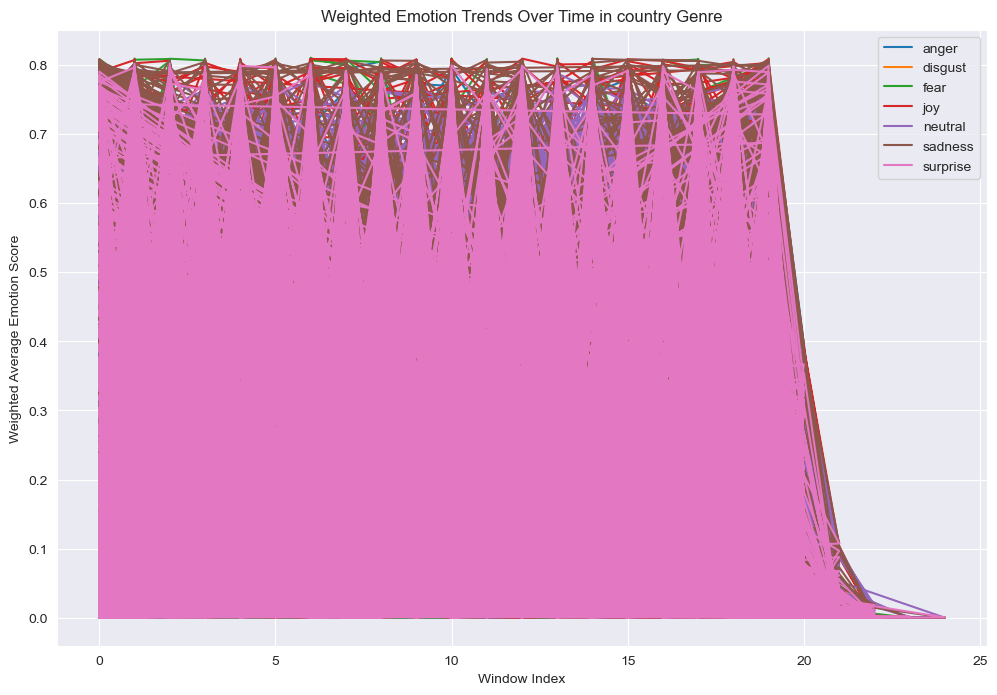

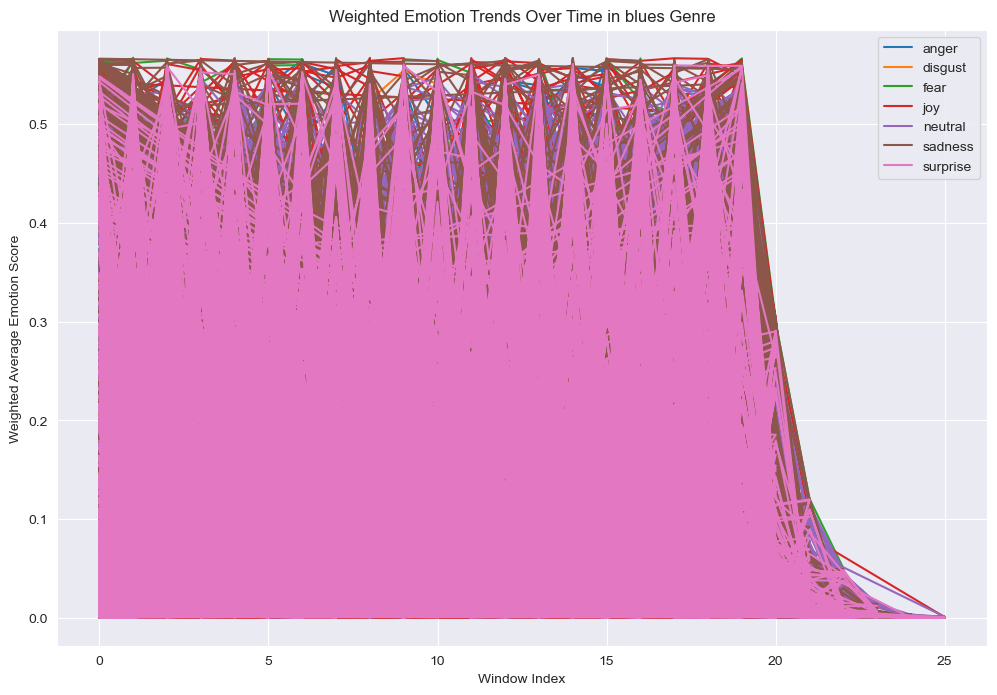

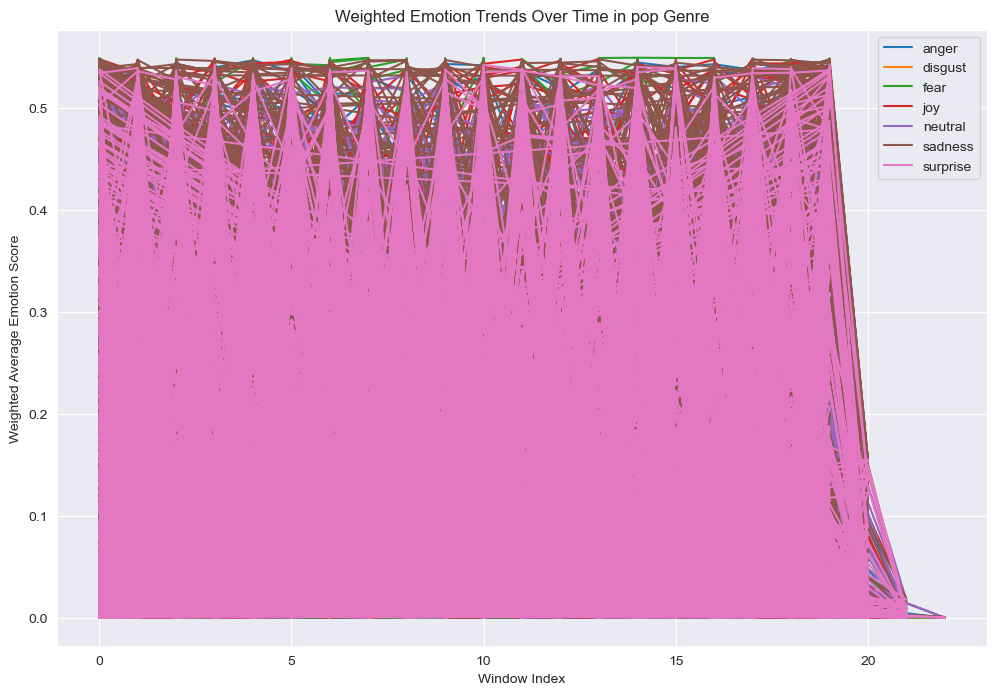

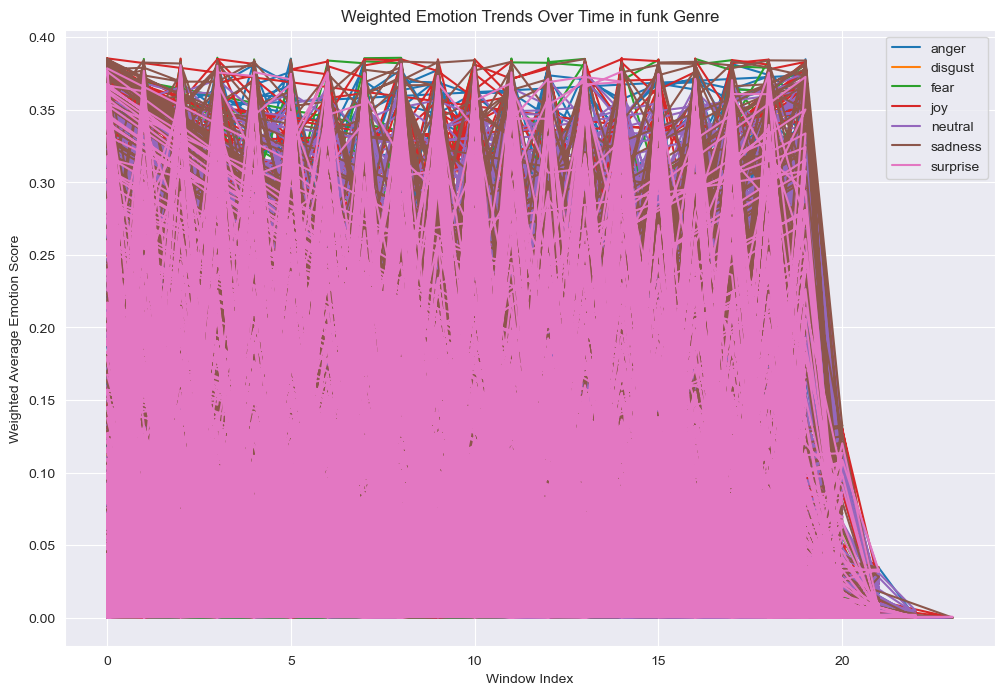

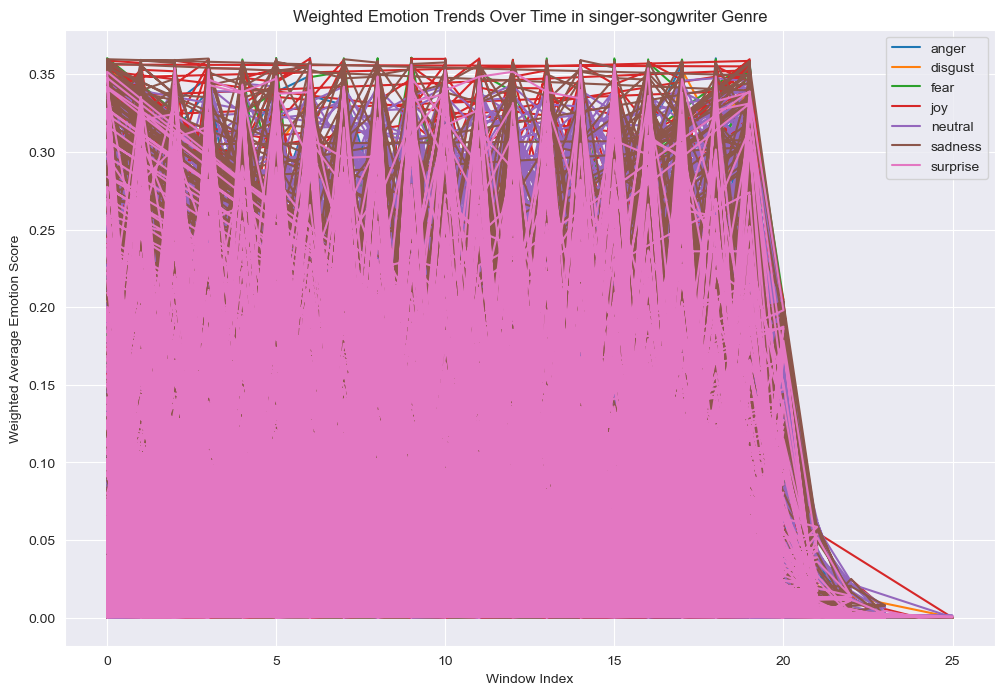

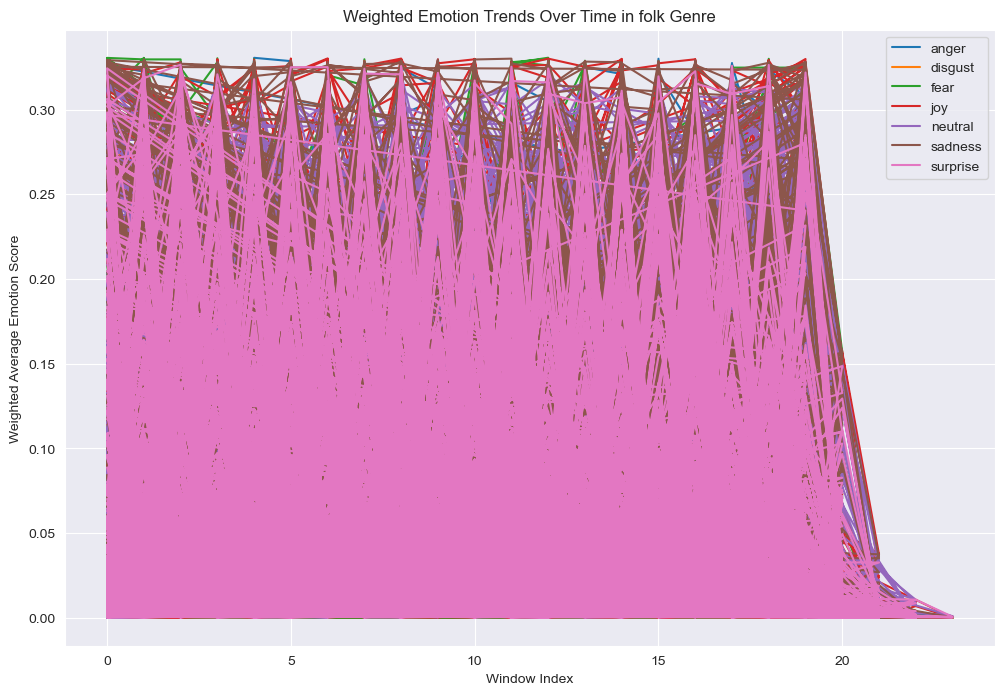

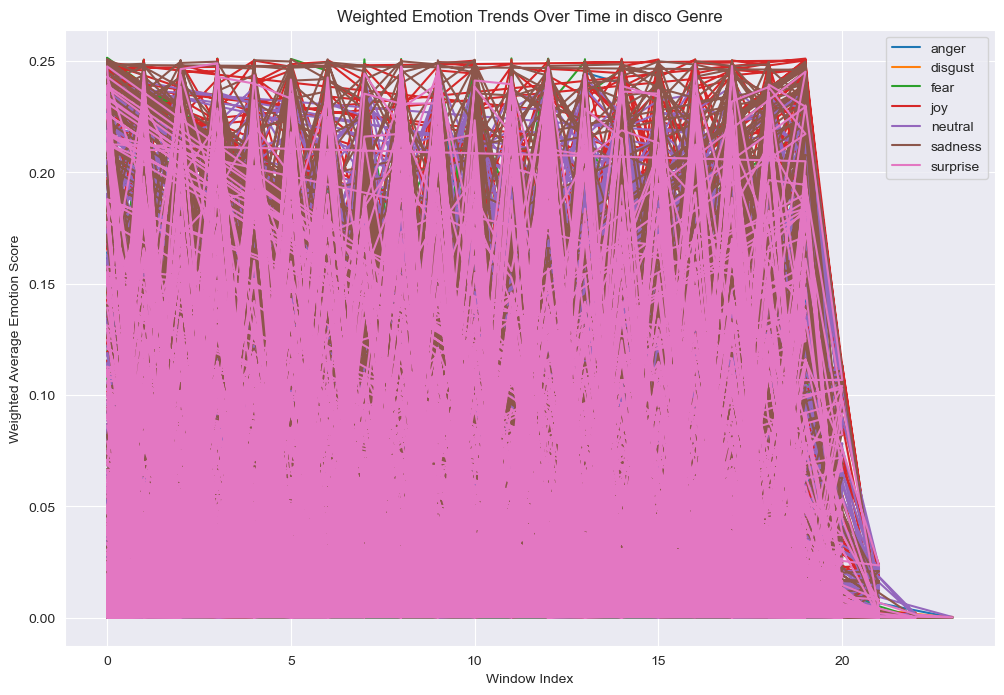

In [27]:
# let's take a look at the top 10 genres by the number of songs

top_genres = eda_df['genre'].value_counts().nlargest(10).index

# filter dataset to include only these top genres
top_genre_df = eda_df[eda_df['genre'].isin(top_genres)]

# calculate the number of songs contributing at each window index per genre
window_song_counts = top_genre_df.groupby(['genre', 'window_index'])['song_clean'].nunique().reset_index()
window_song_counts.columns = ['genre', 'window_index', 'num_songs']

# merge the song counts back into the DataFrame
top_genre_df = top_genre_df.merge(window_song_counts, on=['genre', 'window_index'])

# apply a weight to the emotion scores based on the number of songs at each window index
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

for emotion in emotion_columns:
    top_genre_df[emotion] = top_genre_df[emotion] * top_genre_df['num_songs'] / top_genre_df['num_songs'].max()

# plot the weighted emotional trends for the top 10 genres
for genre in top_genres:
    genre_data = top_genre_df[top_genre_df['genre'] == genre]
    
    plt.figure(figsize=(12, 8))
    for emotion in emotion_columns:
        plt.plot(genre_data['window_index'], genre_data[emotion], label=emotion)

    plt.title(f"Weighted Emotion Trends Over Time in {genre} Genre")
    plt.xlabel("Window Index")
    plt.ylabel("Weighted Average Emotion Score")
    plt.legend(loc='upper right')
    plt.show()


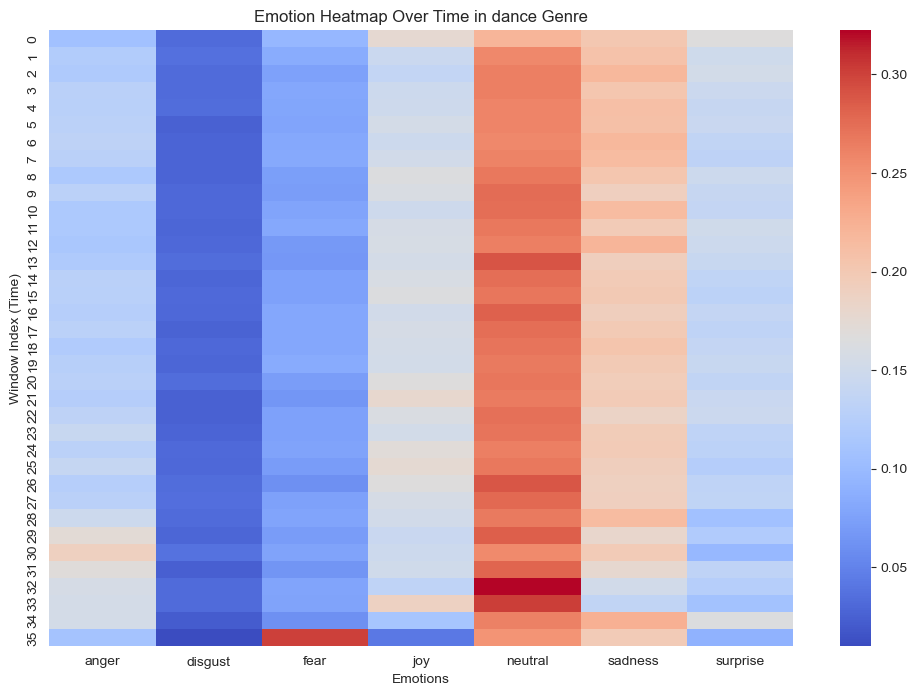

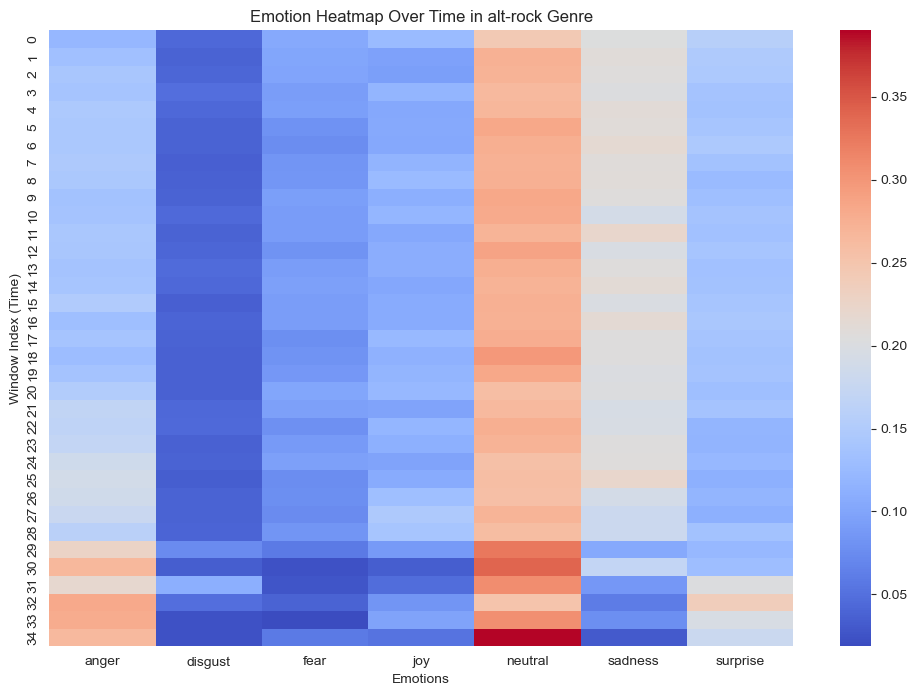

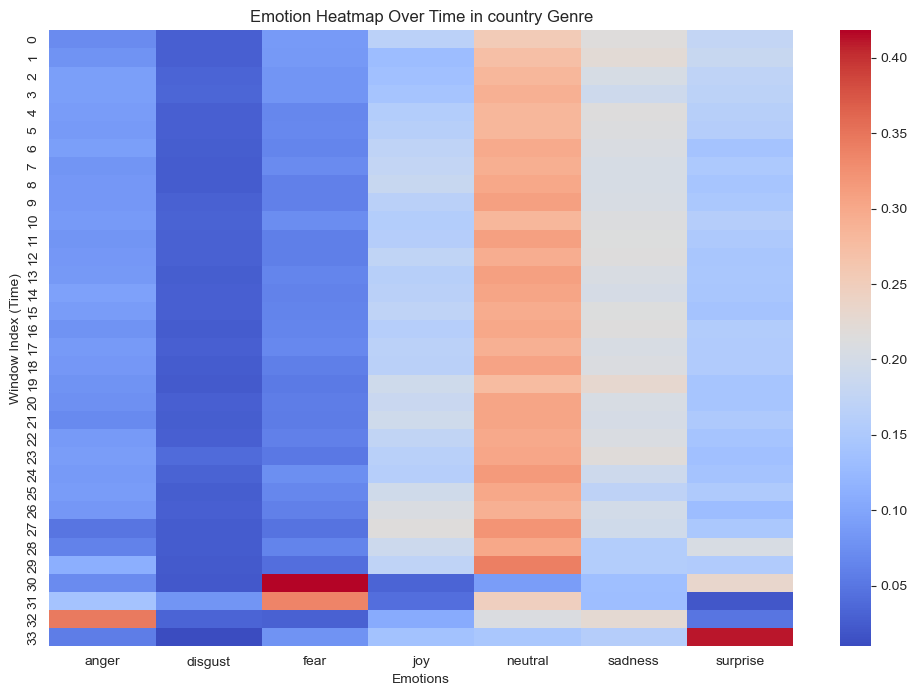

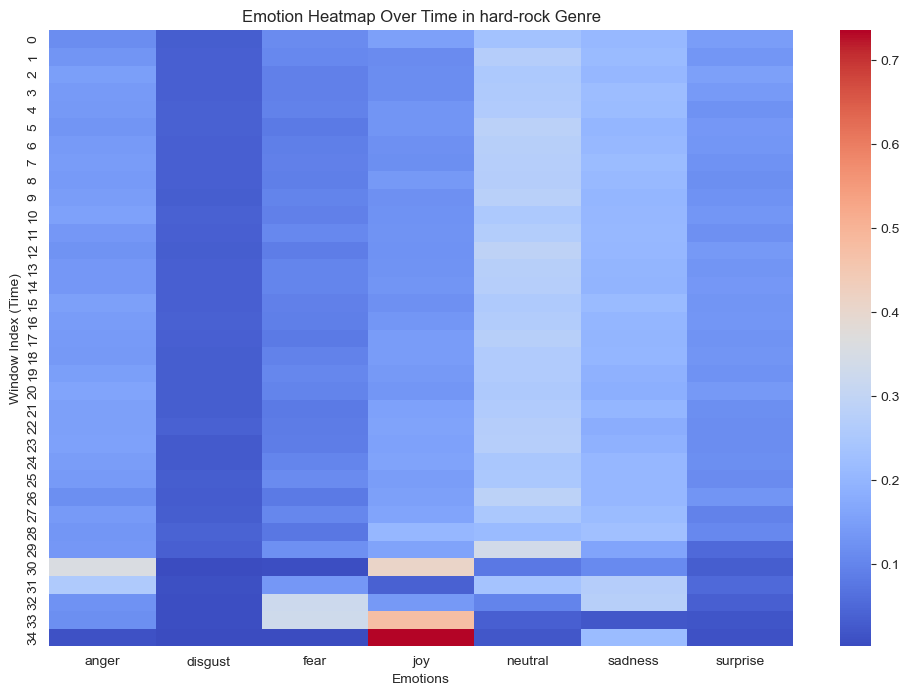

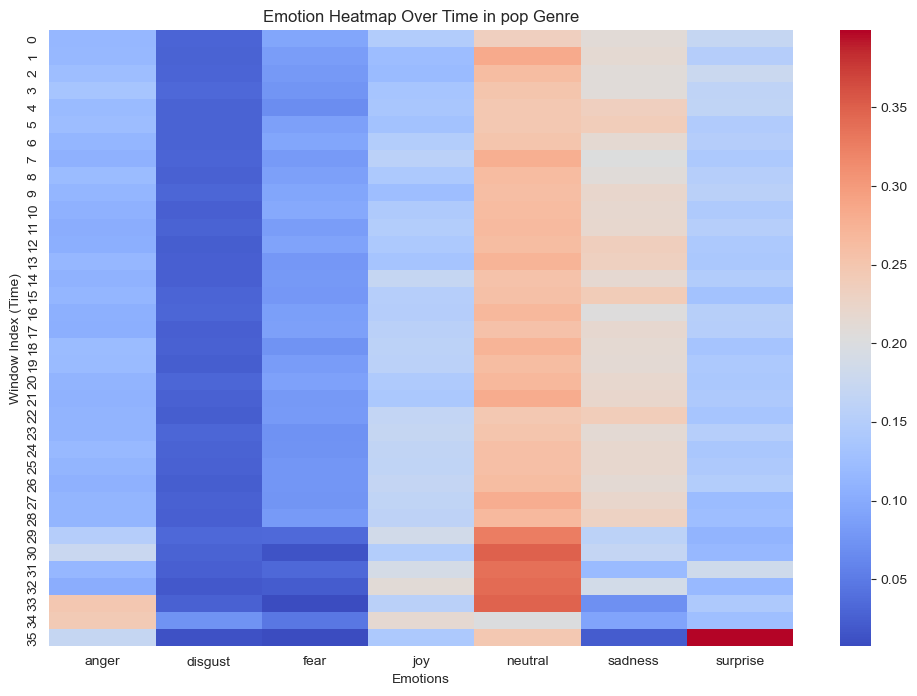

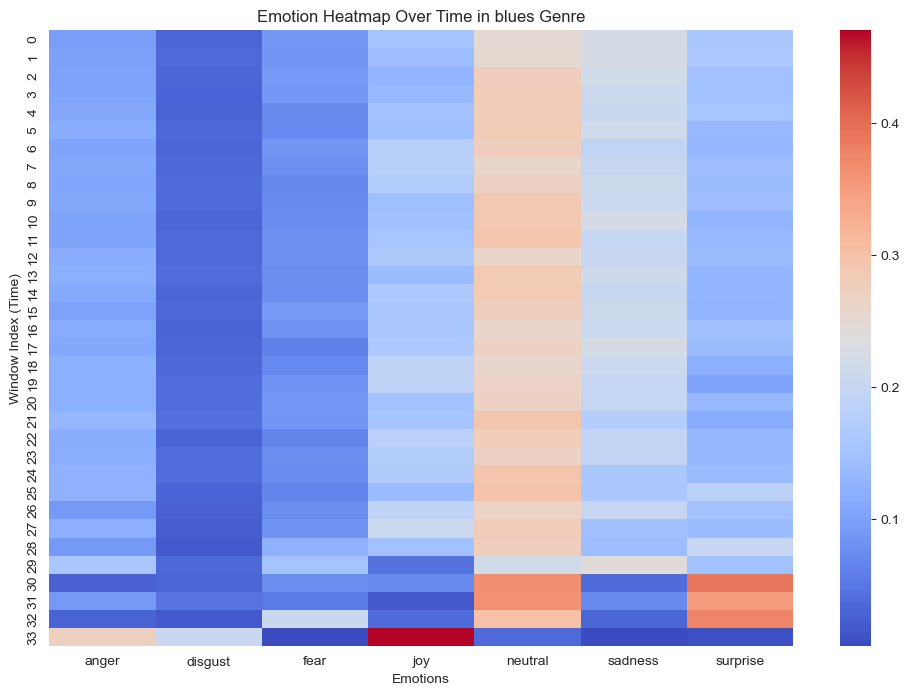

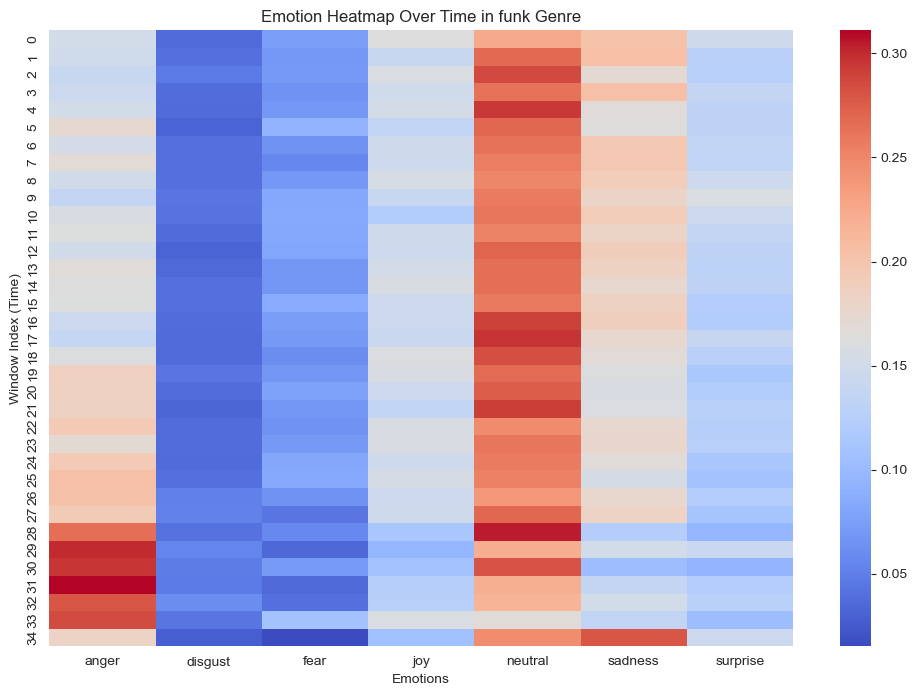

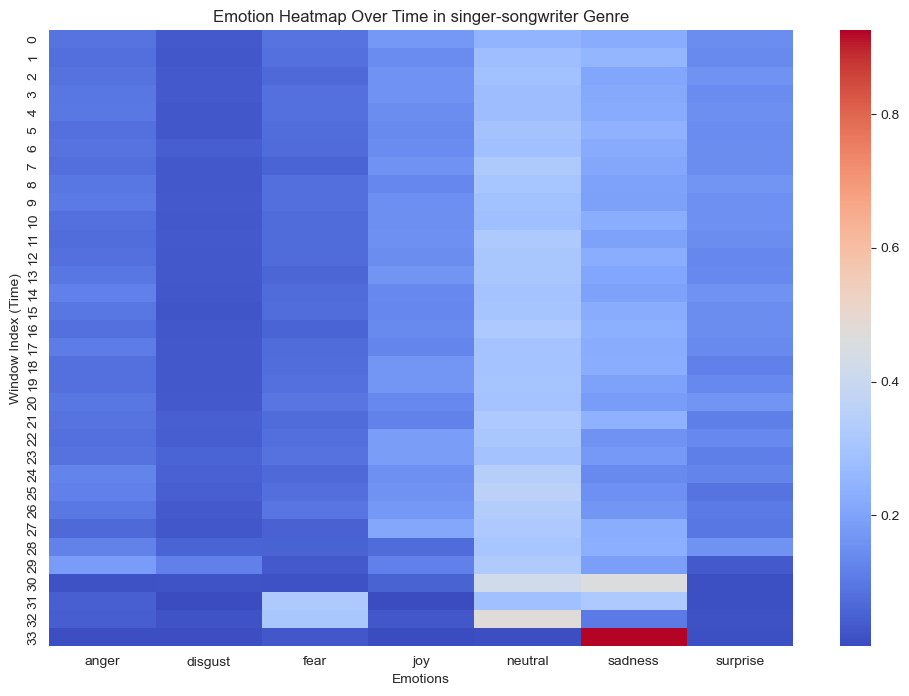

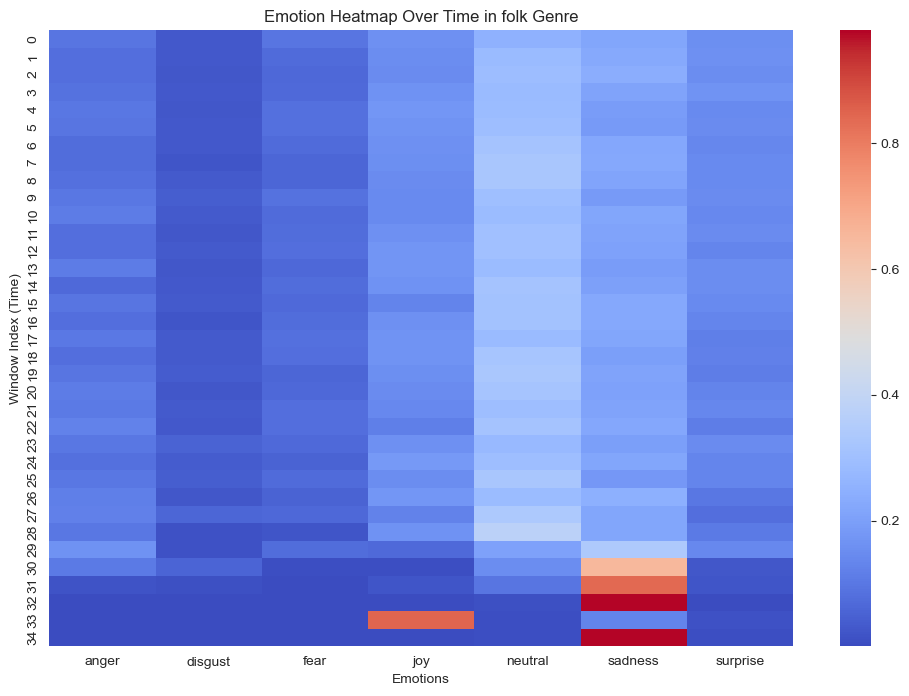

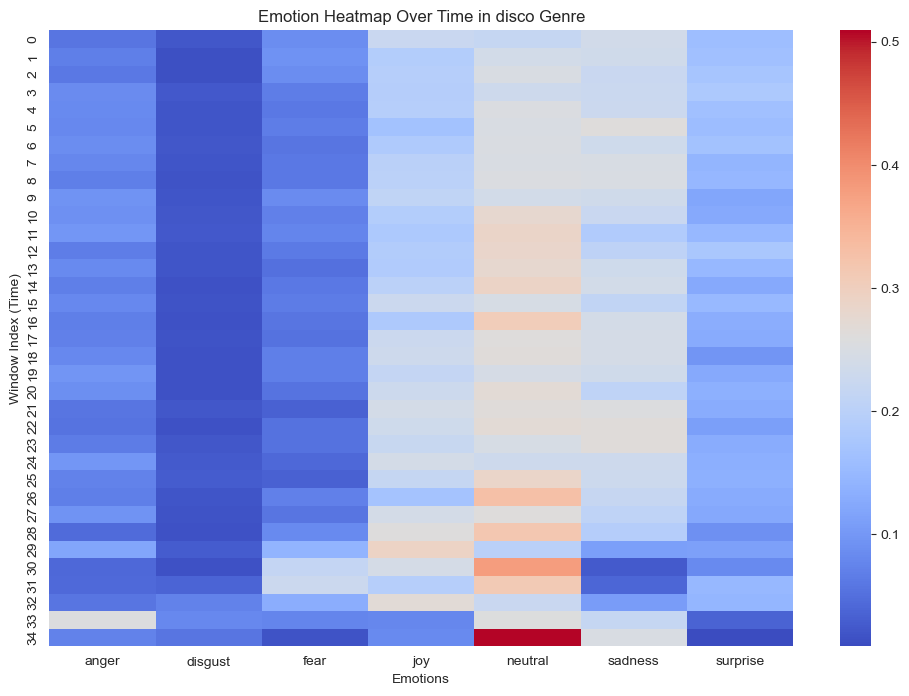

In [12]:
# select the top 10 genres by the number of songs
top_genres = eda_df['genre'].value_counts().nlargest(10).index
top_genre_df = eda_df[eda_df['genre'].isin(top_genres)]

# pivot the data to create a matrix of window_index vs emotions
for genre in top_genres:
    genre_data = top_genre_df[top_genre_df['genre'] == genre].groupby('window_index')[emotion_columns].mean()

    # Plot a heatmap for the current genre
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_data, cmap='coolwarm', annot=False)
    plt.title(f"Emotion Heatmap Over Time in {genre} Genre")
    plt.xlabel("Emotions")
    plt.ylabel("Window Index (Time)")
    plt.show()

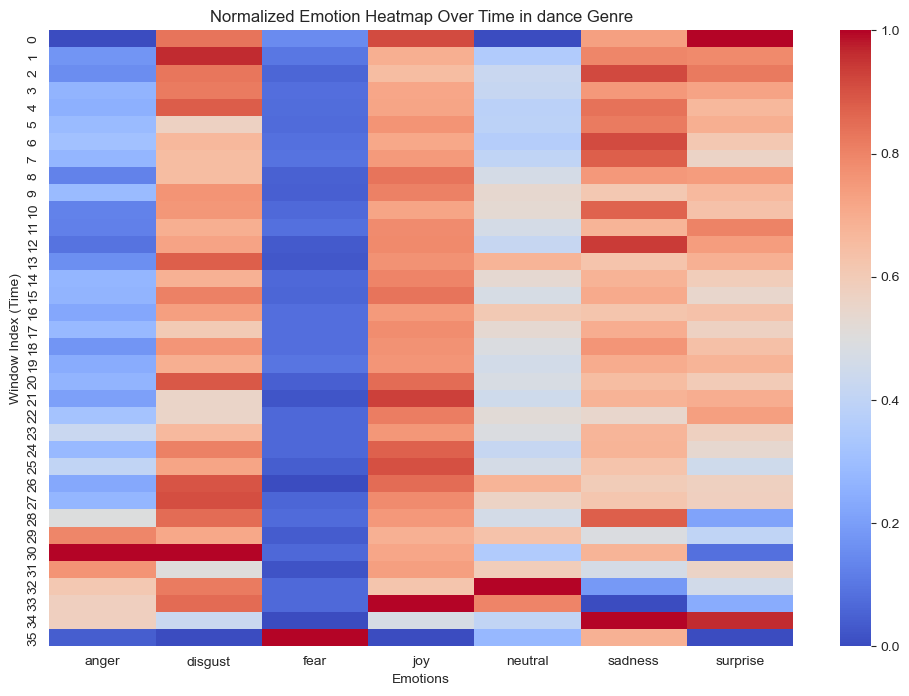

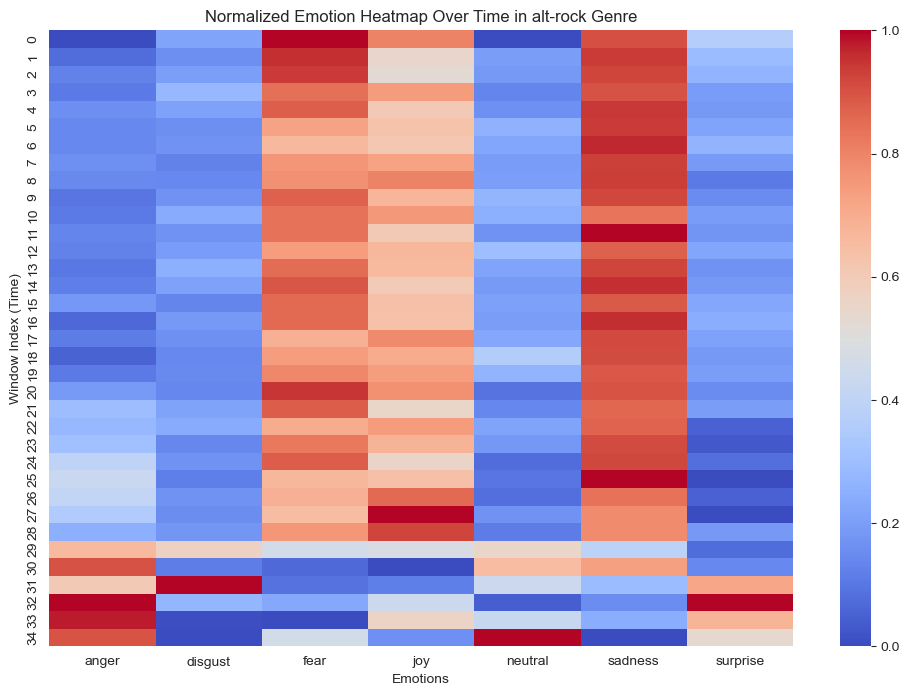

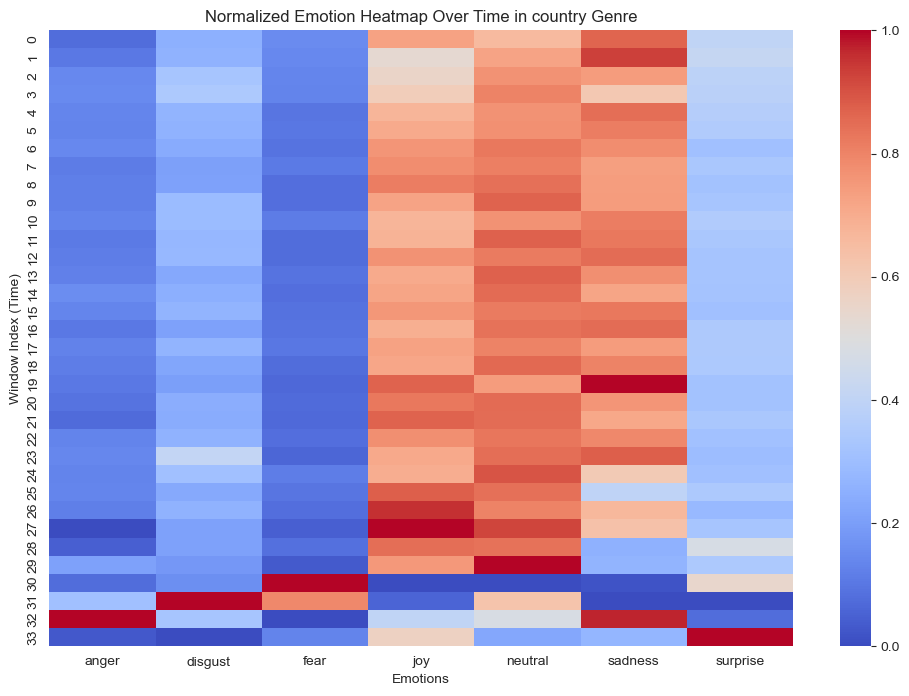

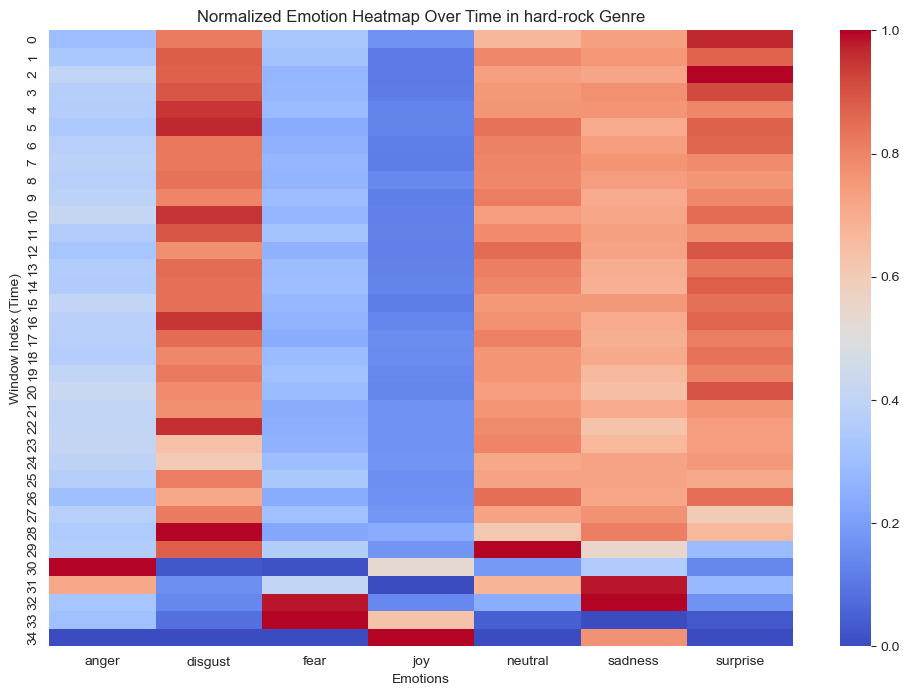

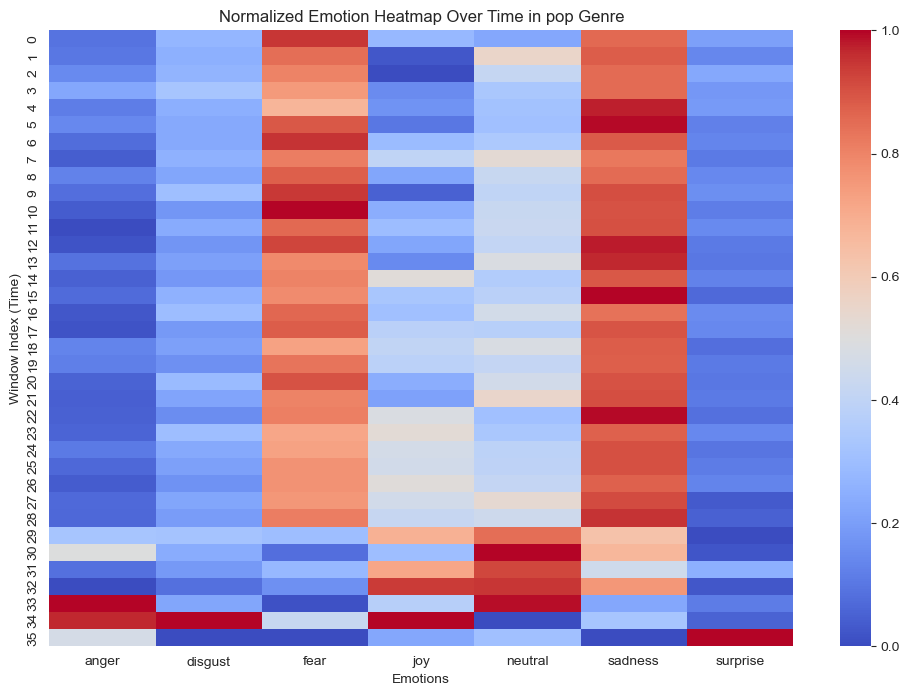

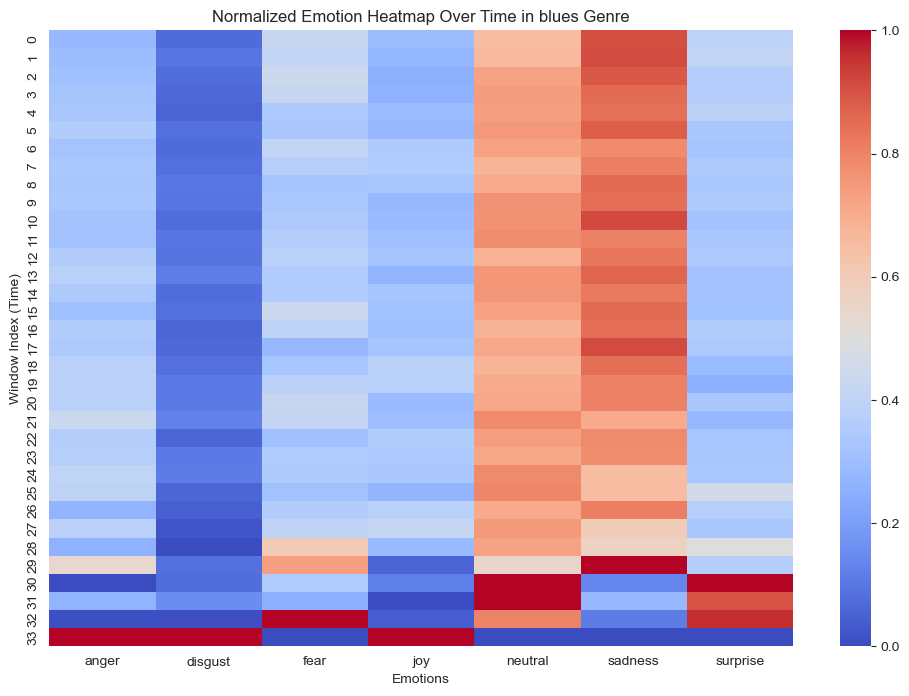

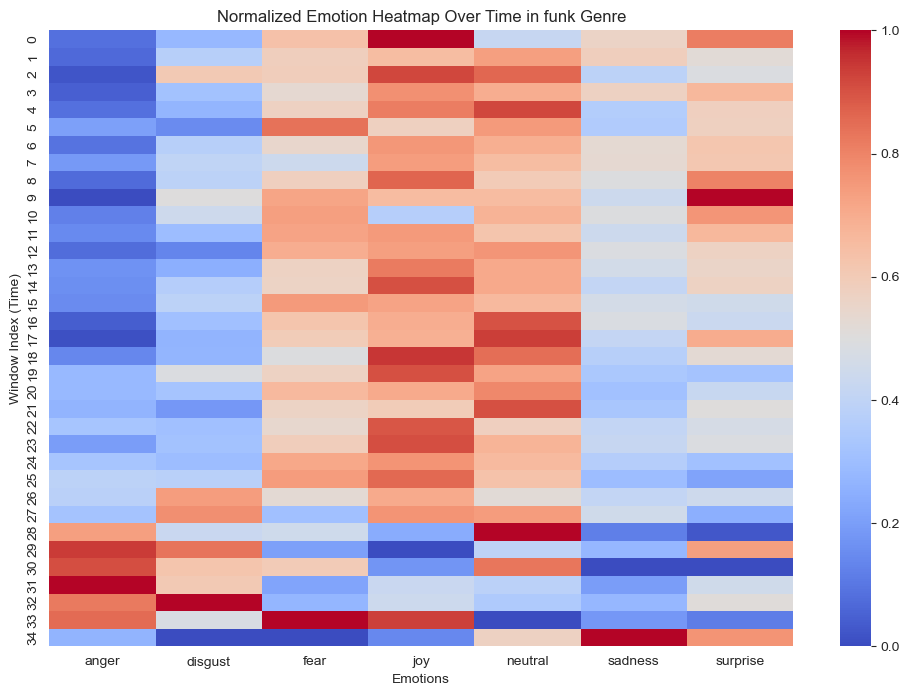

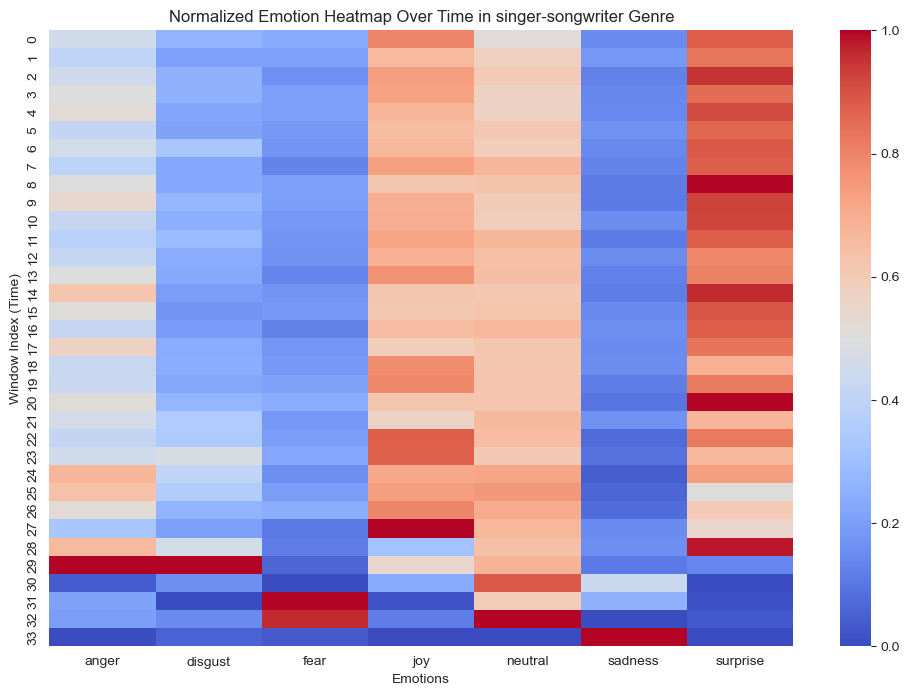

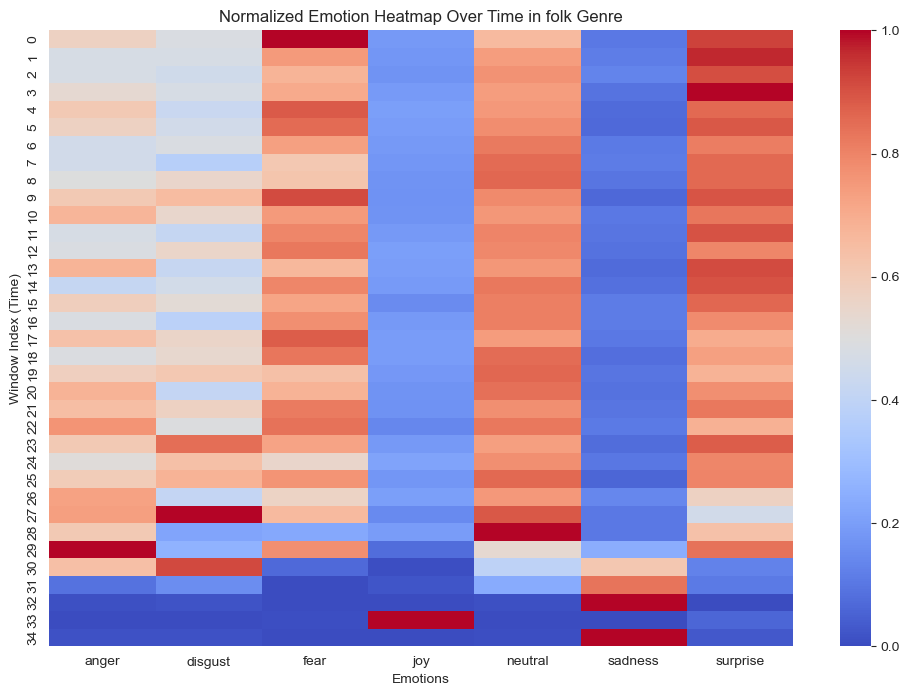

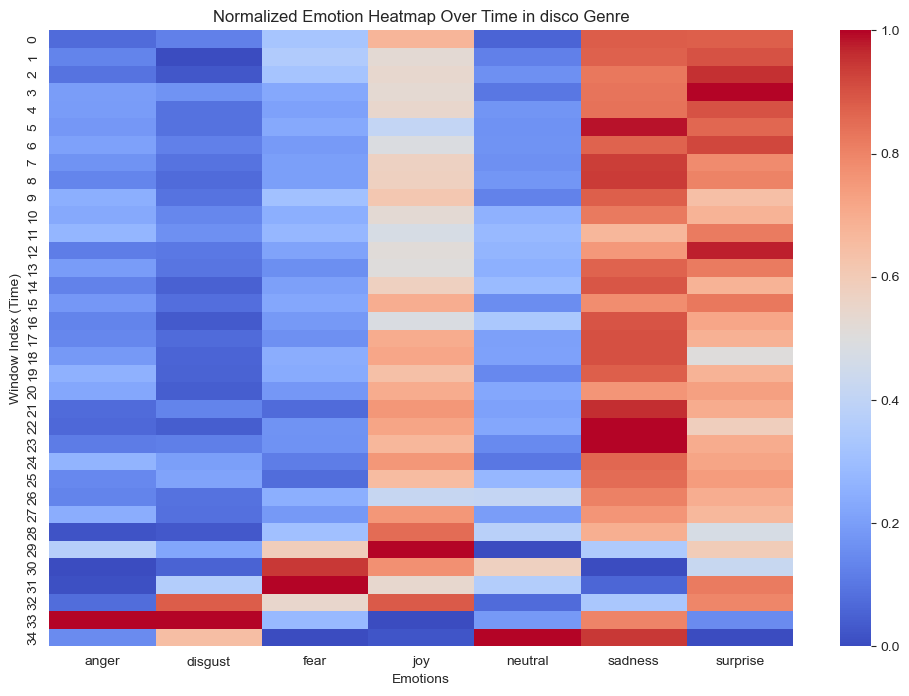

In [13]:
# Function to apply min-max normalization
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

# Step 1: Select the top 10 genres by the number of songs
top_genres = eda_df['genre'].value_counts().nlargest(10).index

# Filter the dataset to include only these top genres
top_genre_df = eda_df[eda_df['genre'].isin(top_genres)]

# Step 2: For each genre, normalize and plot the heatmap
for genre in top_genres:
    # Group by window_index, calculate mean emotion scores, then normalize the values
    genre_data = top_genre_df[top_genre_df['genre'] == genre].groupby('window_index')[emotion_columns].mean()
    normalized_genre_data = normalize(genre_data)  # Apply normalization
    
    # Plot the normalized heatmap for the current genre
    plt.figure(figsize=(12, 8))
    sns.heatmap(normalized_genre_data, cmap='coolwarm', annot=False)
    plt.title(f"Normalized Emotion Heatmap Over Time in {genre} Genre")
    plt.xlabel("Emotions")
    plt.ylabel("Window Index (Time)")
    plt.show()